In [17]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython.display import clear_output
import ipywidgets as widgets
import os

In [18]:
plt.rcParams["figure.figsize"] = (16,8)

In [19]:
dirs = [d for d in os.listdir('.') if os.path.isdir(d)]
dirs = np.sort(dirs)
wFolder = widgets.Dropdown(
    options=dict(zip(dirs,dirs)),
    description='Experiment:',
)
display(wFolder)

A Jupyter Widget

In [20]:
experimentFolder = wFolder.value

In [21]:
nodesAmount = 0
dirs = [d for d in os.listdir(experimentFolder) if os.path.isdir(os.path.join(experimentFolder,d))]
for d in dirs:
    if 'worker' in d:
        nodesAmount += 1
print("Learners amount is ", str(nodesAmount))

Learners amount is  4


Coordinator files

In [22]:
communication = []
files = []

allFiles = [f for f in os.listdir(os.path.join(experimentFolder, "coordinator", "communication"))]

for file in allFiles:
    files.append(open(os.path.join(experimentFolder, "coordinator","communication", file), "r"))

In [23]:
files

[<_io.TextIOWrapper name='deepDrivingExp_nice_2018-10-12 12-17-31\\coordinator\\communication\\registrations.txt' mode='r' encoding='cp1252'>,
 <_io.TextIOWrapper name='deepDrivingExp_nice_2018-10-12 12-17-31\\coordinator\\communication\\send_model.txt' mode='r' encoding='cp1252'>,
 <_io.TextIOWrapper name='deepDrivingExp_nice_2018-10-12 12-17-31\\coordinator\\communication\\violations.txt' mode='r' encoding='cp1252'>]

In [24]:
# coordinator
data_sendModel = files[0]#.read()
data_violations = files[1]#.read()
data_registrations = files[2]#.read()

## Plot

1539339530.805	nodes	newModel.1	33884063	send



ValueError: invalid literal for int() with base 10: 'send\n'

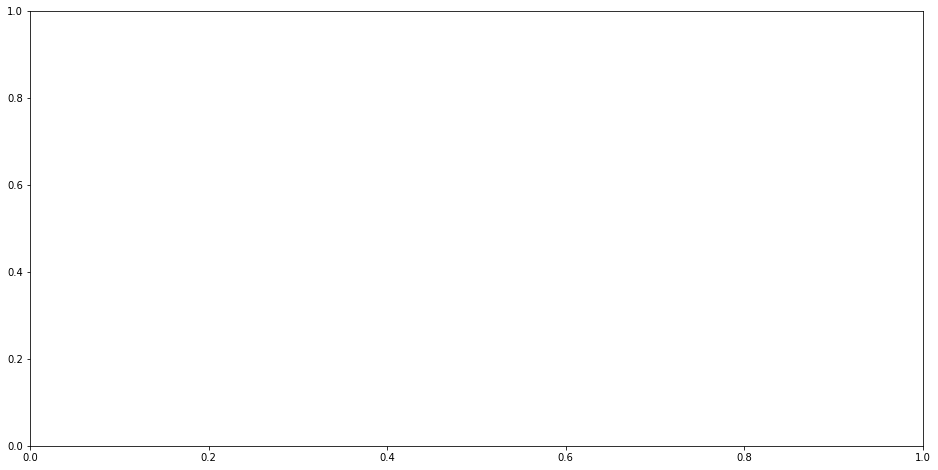

In [26]:
files = []
timestamps = []

for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    timestamps.append([])


t = [0]
commonStep = 0
displayStep = 1
recordStep = 1
recordUnique = True

vlines_buffer = []
rlines_buffer = []
slines_buffer = []

message_size = 0
message_sizes = []

fig = plt.figure()
fig, ax = plt.subplots(1)

while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        else:
            timestamps[i].append(float(line.split('\t')[0]))
            
    currentStep = min([len(ts) for ts in timestamps]) #minimum not needed? just length of any list; because above always one timestamp gets inserted per worker
    if currentStep > commonStep: #if everywhere has been written something
        commonStep = currentStep

        # get synchr timestamp
        # MAYBE IT IS NOT NECESSARY TO CHECK ALL OF THE TIME STAMPS BUT JUST TAKE THOSE OF LAST WORKER...
        # now need to find the largest timestamp; so first of all the worker with most of the time stamps and in there the largest
        if sum(np.array([len(ts) for ts in timestamps])-max([len(ts) for ts in timestamps]))==0: #then all lengths are equal
            #print("equal lengths")
            #print(timestamps)
            time_step = float(np.amax(timestamps))
            #print("maximal time step: " + str(time_step))
        
        else:
            #print("")
            #print("different lengths")
            #print("")
            min_length = min([len(ts) for ts in timestamps])
            # cut lists until min length and take maximal time stamp
            #print("min length: " + str(min_length)) 
            #print([ts[:min_length] for ts in timestamps])
            #print(timestamps)
            #print([ts[:min_length] for ts in timestamps])
            time_step = float(np.amax([ts[:min_length] for ts in timestamps]))
            #print("maximal time step of cut list: "+ str(time_step))


       
        # get data of registration and violation files up to this time step
        #print("CHOSEN TIME STEP:" + str(time_step))
        #check for registrations up to time_step

        while True: 
            # check in buffer (if not empty)
            while rlines_buffer != []: #as long as buffer is not empty
                #print("checking this line in buffer", vlines_buffer[0])
                if float(rlines_buffer[0][0].split("\t")[0]) <= time_step:
                    message_size = message_size + int(rlines_buffer[0][0].split("\t")[4])
                    #print("registration message from buffer added with ts " + str(float(rlines_buffer[0][0].split("\t")[0])))
                    #print("message_size: " + str(message_size))
                    # delete message from buffer
                    rlines_buffer.remove(rlines_buffer[0])
                    #print("buffer after deleting: ", vlines_buffer)
                else: #if first element in buffer is too big then the others in the buffer as well as first elem is smallest
                    break

            # read new lines
            where = data_registrations.tell()
            rline = data_registrations.readline()

            if not rline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_registrations.seek(where)
                break 
            else:
                if float(rline.split("\t")[0]) <= time_step:
                    # here: index 4 = message size
                    message_size = message_size + int(rline.split("\t")[4])
                    #print("registration message added with ts " + str(float(rline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    rlines_buffer.append([rline])
                    break


        #check for sendModels up to time_step
        while True:
            # check in buffer (if not empty)
            while slines_buffer != []: #as long as buffer is not empty
                if float(slines_buffer[0][0].split("\t")[0]) <= time_step:
                    # count number of points in this string which coincides with the number of nodes receiving the model
                    message_size= message_size + int(slines_buffer[0][0].split("\t")[3])* slines_buffer[0][0].split("\t")[2].count(".")
                    #print("sendModel message from buffer added with ts " + str(float(slines_buffer[0][0].split("\t")[0])))
                    #print("message_size: " + str(message_size))
                    # delete message from buffer
                    slines_buffer.remove(slines_buffer[0])
                else:
                    break

            # read new lines
            where = data_sendModel.tell()
            sline = data_sendModel.readline()

            if not sline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_sendModel.seek(where)
                break 
            else:
                if float(sline.split("\t")[0]) <= time_step:
                    # here: index 4 = message size
                    # count number of points in this string which coincides with the number of nodes receiving the model
                    message_size= message_size + int(sline.split("\t")[3])* sline.split("\t")[2].count(".")
                    #print("sendModel message added with ts " + str(float(sline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    slines_buffer.append([sline])
                    break


        #check for violations up to time_step
        while True:
            # check in buffer (if not empty)
            #print("buffer", vlines_buffer)
            while vlines_buffer != []: #as long as buffer is not empty
                #print("checking this line in buffer", vlines_buffer[0])
                if float(vlines_buffer[0][0].split("\t")[0]) <= time_step:
                    message_size = message_size + int(vlines_buffer[0][0].split("\t")[4])
                    #print("violation message from buffer added with ts " + str(float(vlines_buffer[0][0].split("\t")[0])))
                    #print("message_size: " + str(message_size))
                    # delete message from buffer
                    vlines_buffer.remove(vlines_buffer[0])
                    #print("buffer after deleting: ", vlines_buffer)
                else: #if first element in buffer is too big then the others in the buffer as well as first elem is smallest
                    break

            # read new lines
            where = data_violations.tell()
            vline = data_violations.readline()

            if not vline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_violations.seek(where)
                break 
            else:
                if float(vline.split("\t")[0]) <= time_step:
                    # here: index 4 = message size
                    print(vline)
                    message_size = message_size + int(vline.split("\t")[4])
                    #print("violation message added with ts " + str(float(vline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    vlines_buffer.append([vline])
                    break


        message_sizes.append(message_size)
        #print("message_sizes: " + str(message_sizes))
        
        if commonStep % displayStep == 0:


            clear_output(wait=True)

            #fig = plt.figure()
            fig, ax = plt.subplots(1)
            plt.plot(t, message_sizes, lw=4, label='cumulative communication', color='blue')
            #plt.legend(loc='upper center')
            plt.grid()
            plt.xlim(0,260)
            plt.ylim(0,3.5*1e9)
            plt.tick_params(colors=(0,0,0,0))
            plt.show()
        t.append(t[-1] + 1)
        if len(t) % recordStep == 0 and t != 0:
            j = 0
            if recordUnique:
                extent = ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
                #gca().set_axis_off()
                #plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
                #plt.margins(0,0)
                #plt.gca().xaxis.set_major_locator(matplotlib.ticker.NullLocator())
                #plt.gca().yaxis.set_major_locator(matplotlib.ticker.NullLocator())
                fig.savefig(os.path.join(experimentFolder, 'layout_cumulative_communication' + str(len(t)) + '.png'), dpi=100,bbox_inches=extent)
            else:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_communication.png'), dpi=100)
            j += 1


## Old: Buffer here behaved wrongly: after deleting, the first element didn't get checked

CHOSEN TIME STEP:1539339549.389
buffer []
new line:  1539339562.223	coordinator	violation	0	33884044	receive

message_sizes: [135536480]
CHOSEN TIME STEP:1539339555.37
buffer [['1539339562.223\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539339562.223\tcoordinator\tviolation\t0\t33884044\treceive\n']
new line:  1539339572.153	coordinator	violation	1	33884044	receive

message_sizes: [135536480, 135536480]
CHOSEN TIME STEP:1539339561.391
buffer [['1539339562.223\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339572.153\tcoordinator\tviolation\t1\t33884044\treceive\n']]
checking this line in buffer ['1539339562.223\tcoordinator\tviolation\t0\t33884044\treceive\n']
new line:  1539339572.476	coordinator	violation	2	33884044	receive

message_sizes: [135536480, 135536480, 135536480]
CHOSEN TIME STEP:1539339567.529
buffer [['1539339562.223\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339572.153\tcoordinator\tviolation\t1\t33884044\tre

<Figure size 1152x576 with 0 Axes>

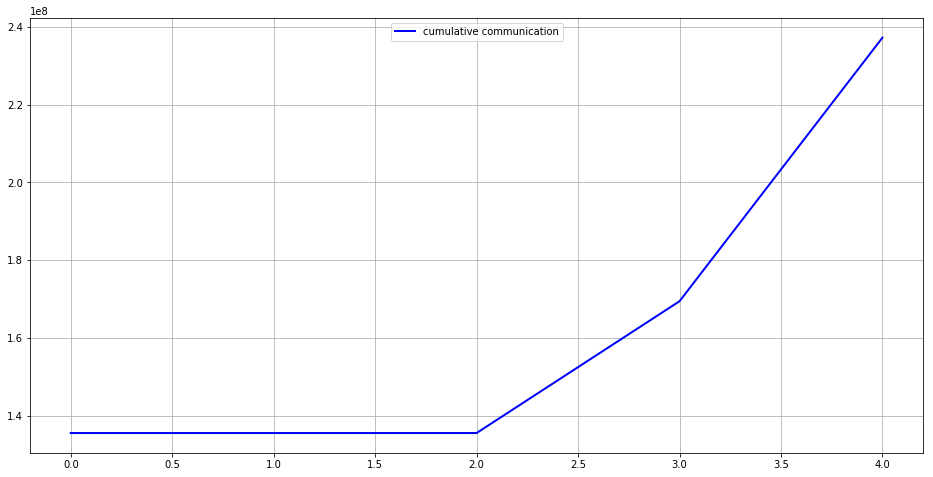

CHOSEN TIME STEP:1539339579.226
buffer [['1539339580.190\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339584.401\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539339580.190\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  1539339602.892	coordinator	violation	1	33884044	receive

message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612]
CHOSEN TIME STEP:1539339586.298
buffer [['1539339580.190\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339584.401\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339602.892\tcoordinator\tviolation\t1\t33884044\treceive\n']]
checking this line in buffer ['1539339580.190\tcoordinator\tviolation\t3\t33884044\treceive\n']
violation message from buffer added with ts 1539339580.19
message_size: 406608908
buffer after deleting:  [['1539339584.401\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339602.892\tcoordinator\tviolation\t1\t33884044\treceive\

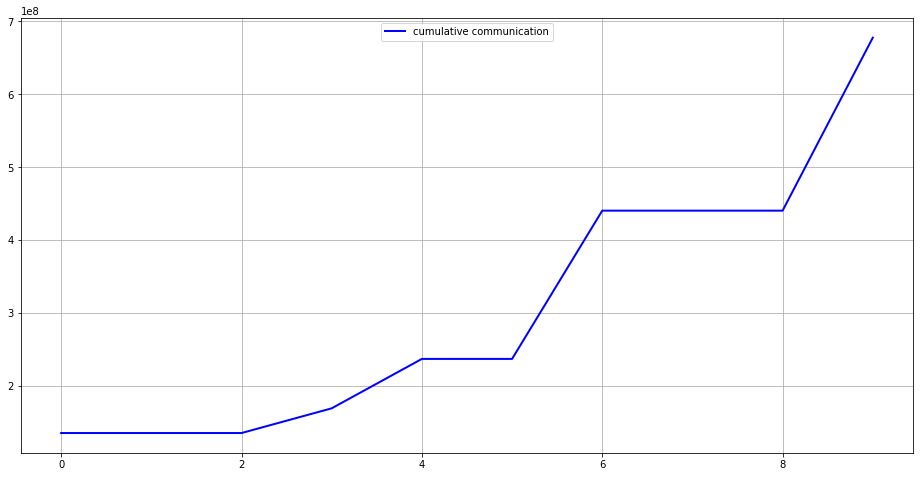

CHOSEN TIME STEP:1539339611.573
buffer [['1539339610.469\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339628.022\tcoordinator\tviolation\t1\t33884044\treceive\n']]
checking this line in buffer ['1539339610.469\tcoordinator\tviolation\t0\t33884044\treceive\n']
violation message from buffer added with ts 1539339610.469
message_size: 711565380
buffer after deleting:  [['1539339628.022\tcoordinator\tviolation\t1\t33884044\treceive\n']]
checking this line in buffer ['1539339628.022\tcoordinator\tviolation\t1\t33884044\treceive\n']
new line:  1539339630.744	coordinator	violation	3	33884044	receive

message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380]
CHOSEN TIME STEP:1539339617.637
buffer [['1539339628.022\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539339630.744\tcoordinator\tviolation\t3\t33884044\treceive\n']]
checking this line in buffer ['1539339628.022\tcoordinator\tviolation\t1\t3

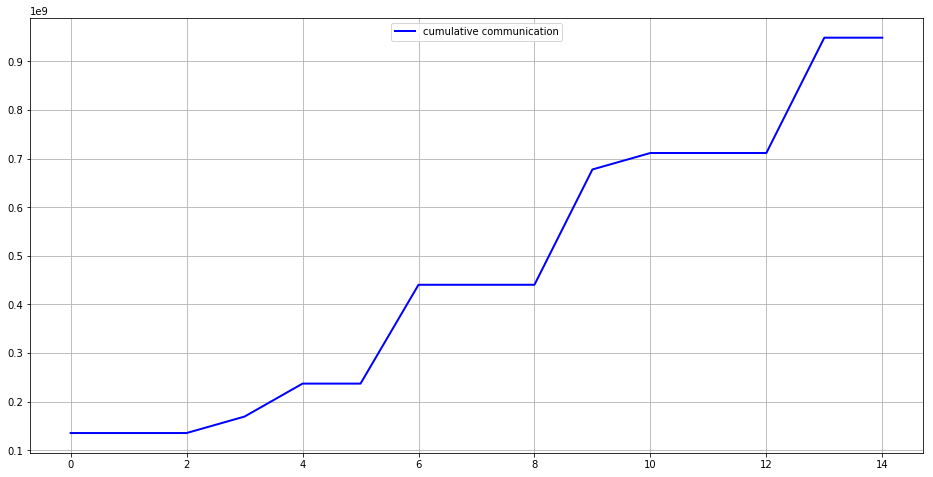

CHOSEN TIME STEP:1539339642.587
buffer [['1539339638.399\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339655.689\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339659.142\tcoordinator\tviolation\t1\t33884044\treceive\n']]
checking this line in buffer ['1539339638.399\tcoordinator\tviolation\t0\t33884044\treceive\n']
violation message from buffer added with ts 1539339638.399
message_size: 982637808
buffer after deleting:  [['1539339655.689\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339659.142\tcoordinator\tviolation\t1\t33884044\treceive\n']]
checking this line in buffer ['1539339655.689\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  1539339665.384	coordinator	violation	2	33884044	receive

message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 948753764, 982637808]
CHOSEN TIME STEP:1539339666.671
buffer [['1539339655.689\tco

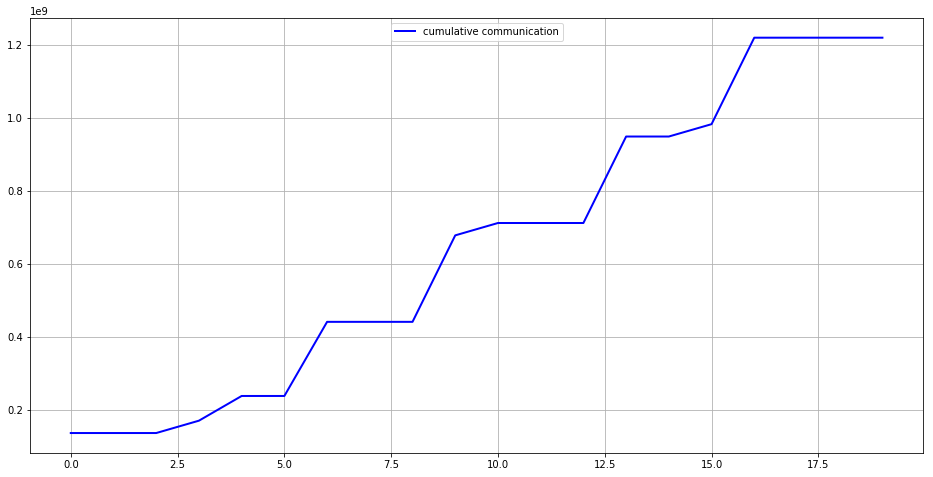

CHOSEN TIME STEP:1539339703.269
buffer [['1539339670.493\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339686.433\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339696.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539339701.946\tcoordinator\tviolation\t2\t33884044\treceive\n']]
checking this line in buffer ['1539339670.493\tcoordinator\tviolation\t0\t33884044\treceive\n']
violation message from buffer added with ts 1539339670.493
message_size: 1389246488
buffer after deleting:  [['1539339686.433\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339696.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539339701.946\tcoordinator\tviolation\t2\t33884044\treceive\n']]
checking this line in buffer ['1539339686.433\tcoordinator\tviolation\t3\t33884044\treceive\n']
violation message from buffer added with ts 1539339686.433
message_size: 1423130532
buffer after deleting:  [['1539339696.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539

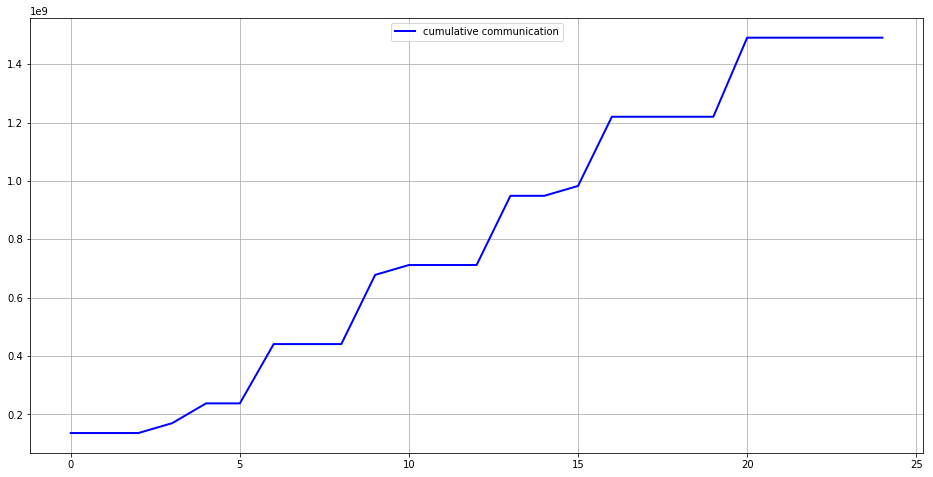

CHOSEN TIME STEP:1539339757.981
buffer [['1539339708.267\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339723.541\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339739.584\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539339756.636\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539339765.155\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539339708.267\tcoordinator\tviolation\t0\t33884044\treceive\n']
violation message from buffer added with ts 1539339708.267
message_size: 1660318916
buffer after deleting:  [['1539339723.541\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339739.584\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539339756.636\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539339765.155\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539339723.541\tcoordinator\tviolation\t3\t33884044\treceive\n']
violation message from buffer added with ts 153

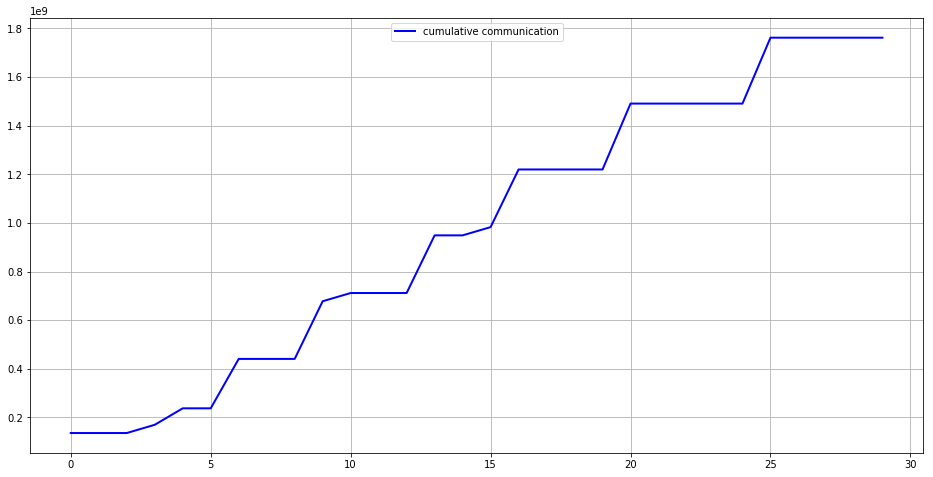

CHOSEN TIME STEP:1539339763.211
buffer [['1539339765.155\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339772.376\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339806.135\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539339860.314\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539339872.772\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339874.336\tcoordinator\tviolation\t3\t33884044\treceive\n']]
checking this line in buffer ['1539339765.155\tcoordinator\tviolation\t0\t33884044\treceive\n']
new line:  1539339956.036	coordinator	violation	1	33884044	receive

message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 948753764, 982637808, 1219826192, 1219826192, 1219826192, 1219826192, 1490898620, 1490898620, 1490898620, 1490898620, 1490898620, 1761971048, 1761971048, 1761971048, 1761971048, 1761971048, 1761971048]
CHOSEN TIME STEP

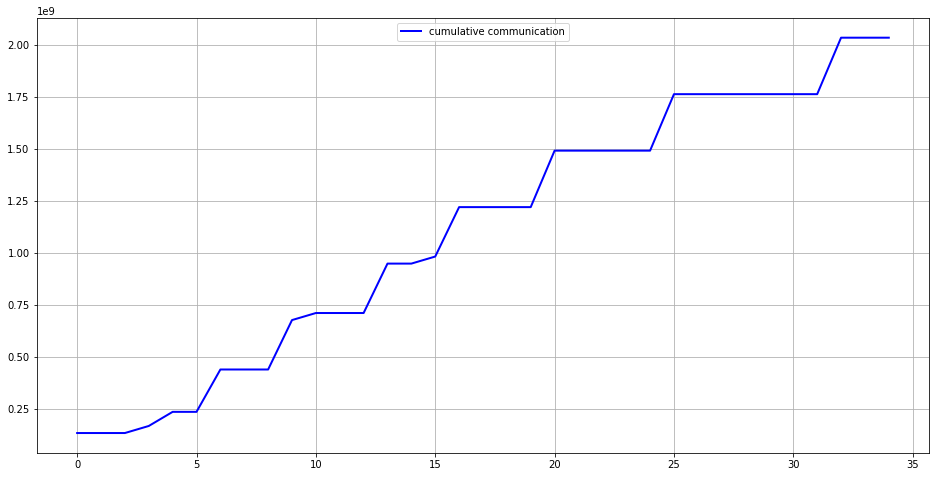

CHOSEN TIME STEP:1539339864.595
buffer [['1539339872.772\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339874.336\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339956.036\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340069.454\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340089.953\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340103.417\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340291.398\tcoordinator\tviolation\t1\t33884044\treceive\n']]
checking this line in buffer ['1539339872.772\tcoordinator\tviolation\t0\t33884044\treceive\n']
new line:  1539340488.499	coordinator	violation	2	33884044	receive

message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 948753764, 982637808, 1219826192, 1219826192, 1219826192, 1219826192, 1490898620, 1490898620, 1490898620, 1490898620, 1490898620, 1761971048, 17619710

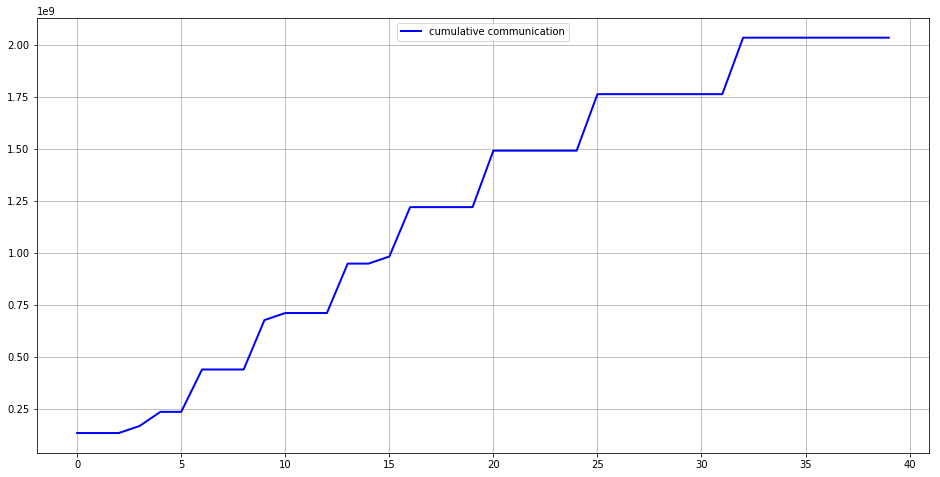

CHOSEN TIME STEP:1539339869.75
buffer [['1539339872.772\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539339874.336\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539339956.036\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340069.454\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340089.953\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340103.417\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340291.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340488.499\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n']]
checking this line in buffer ['1539339872.772\tcoordinator\tviolation\t0\t33884044\treceive\n']
new line:  1539341349.130	coordinator	violation	3

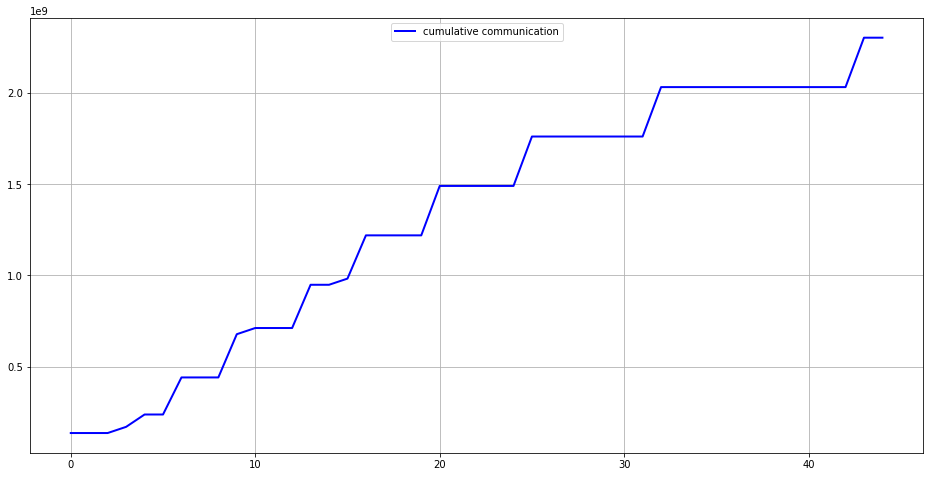

CHOSEN TIME STEP:1539340072.926
buffer [['1539340089.953\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340103.417\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340291.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340488.499\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n']]
checking this line in buffer ['1539340089.953\tcoordinator\tviolation\t3\t33

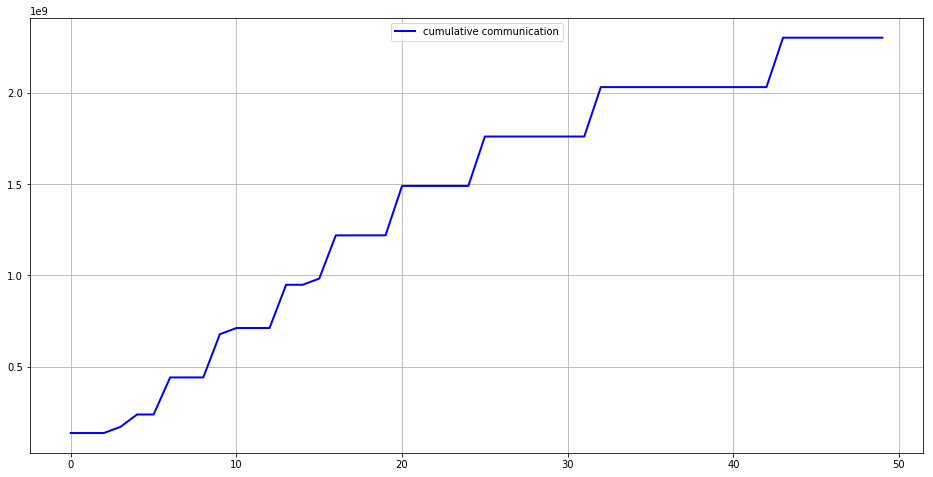

CHOSEN TIME STEP:1539340077.89
buffer [['1539340089.953\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340103.417\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340291.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340488.499\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking 

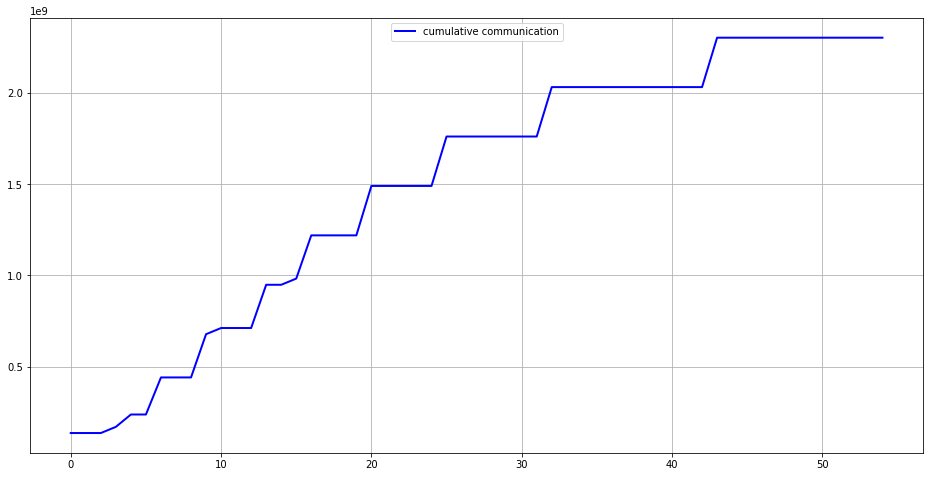

CHOSEN TIME STEP:1539340082.884
buffer [['1539340089.953\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340103.417\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340291.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340488.499\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking

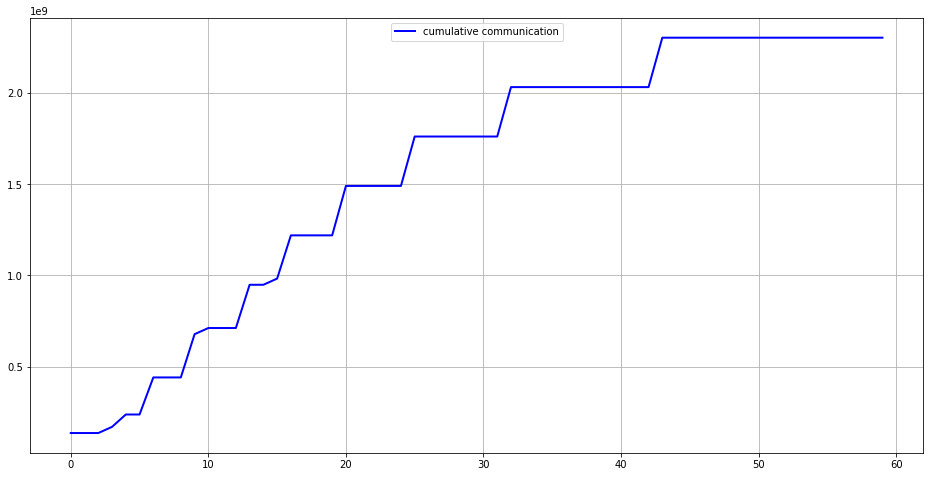

CHOSEN TIME STEP:1539340088.008
buffer [['1539340089.953\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340103.417\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340291.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340488.499\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking

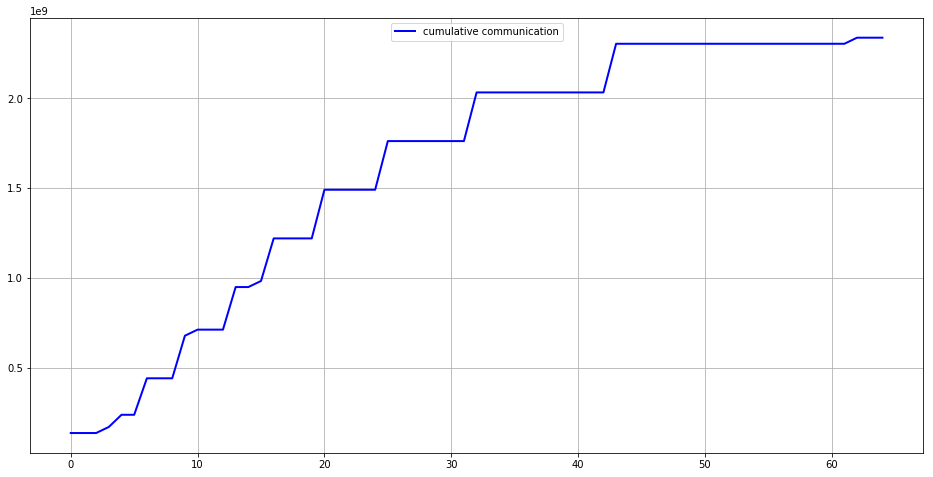

CHOSEN TIME STEP:1539340093.073
buffer [['1539340103.417\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340291.398\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539340488.499\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340103.417\tcoordinator\tviolation\t0\t33

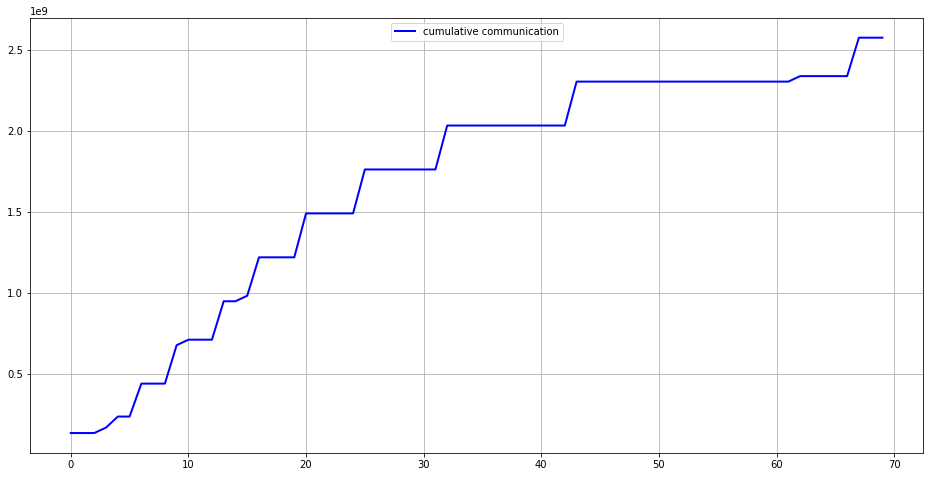

CHOSEN TIME STEP:1539340492.938
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

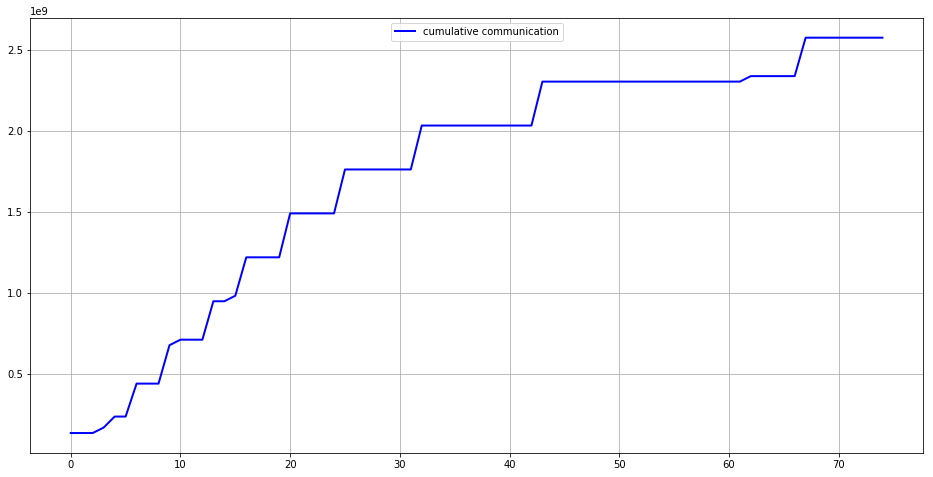

CHOSEN TIME STEP:1539340497.967
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

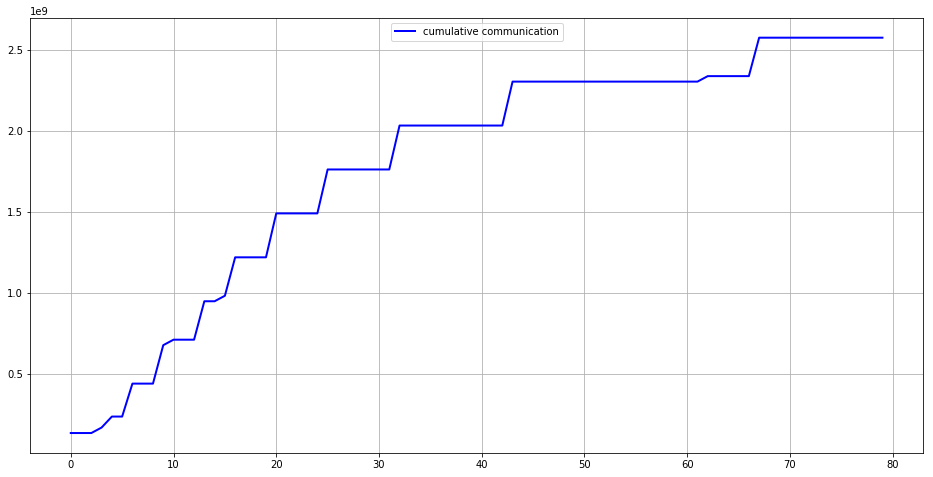

CHOSEN TIME STEP:1539340502.781
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

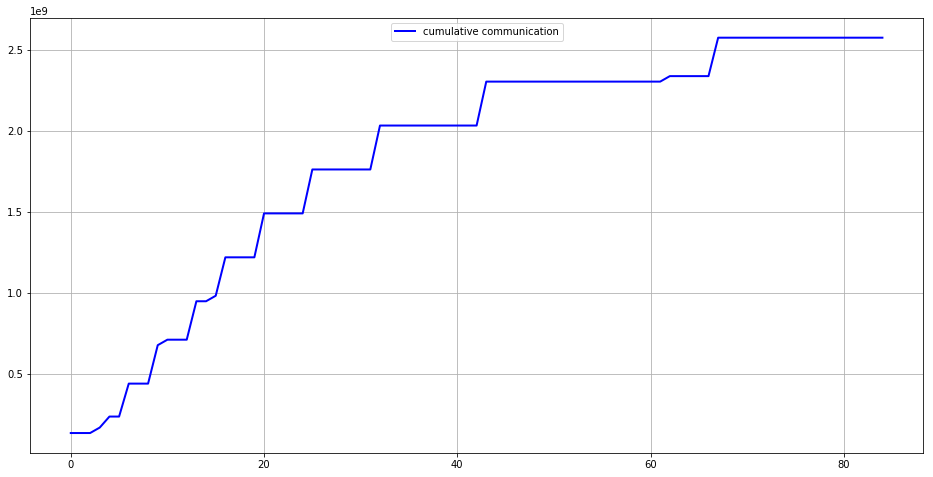

CHOSEN TIME STEP:1539340507.816
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

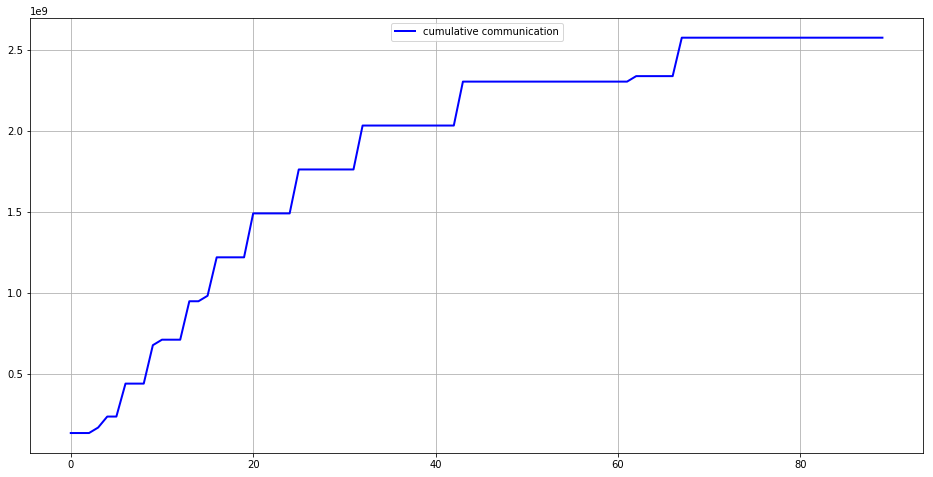

CHOSEN TIME STEP:1539340512.972
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

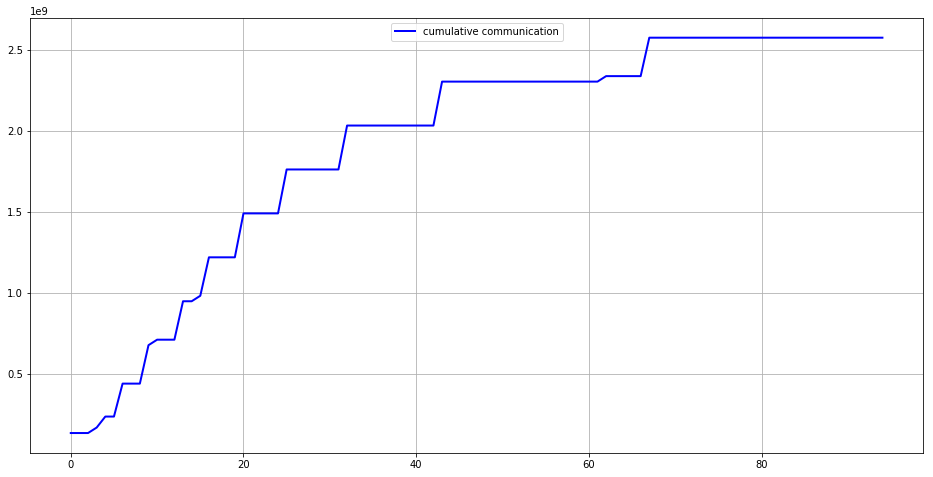

CHOSEN TIME STEP:1539340517.95
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 948

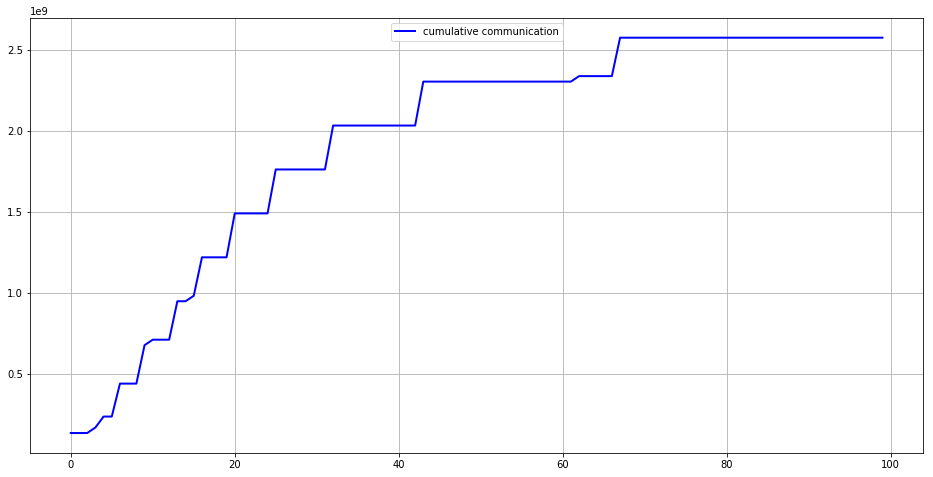

CHOSEN TIME STEP:1539340522.864
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

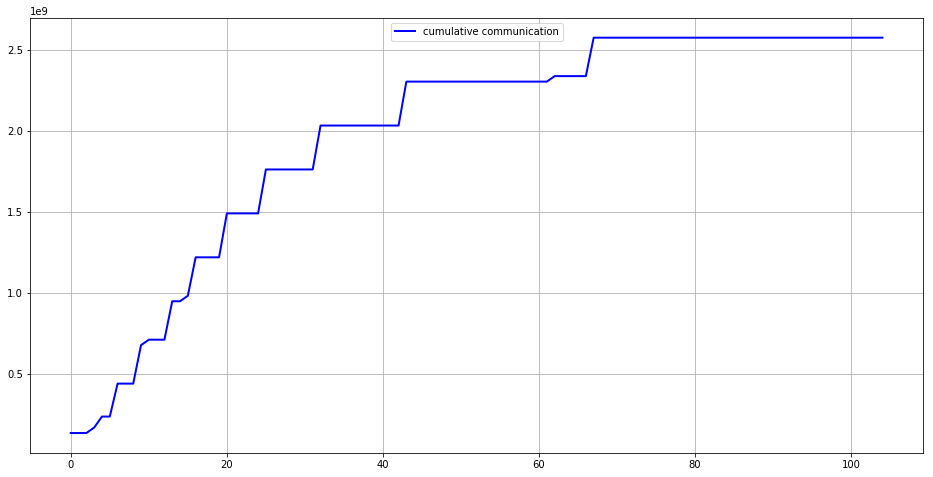

CHOSEN TIME STEP:1539340527.847
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

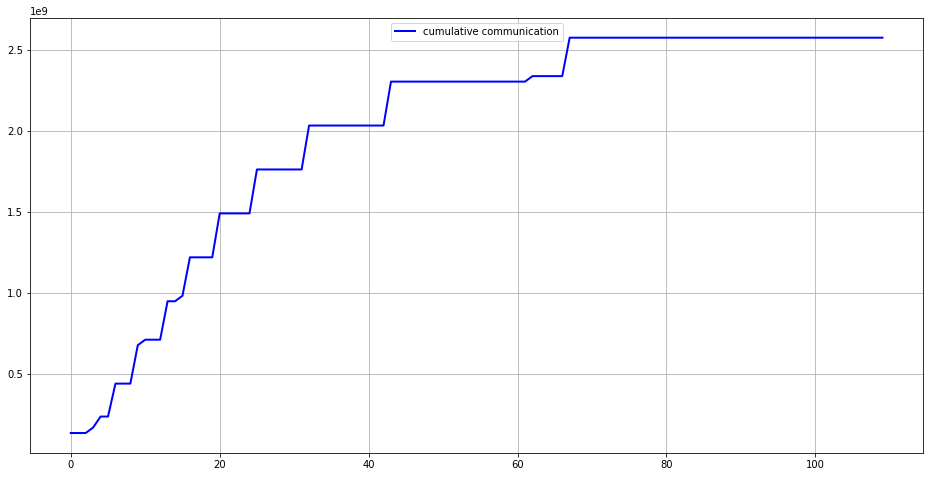

CHOSEN TIME STEP:1539340532.87
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 948

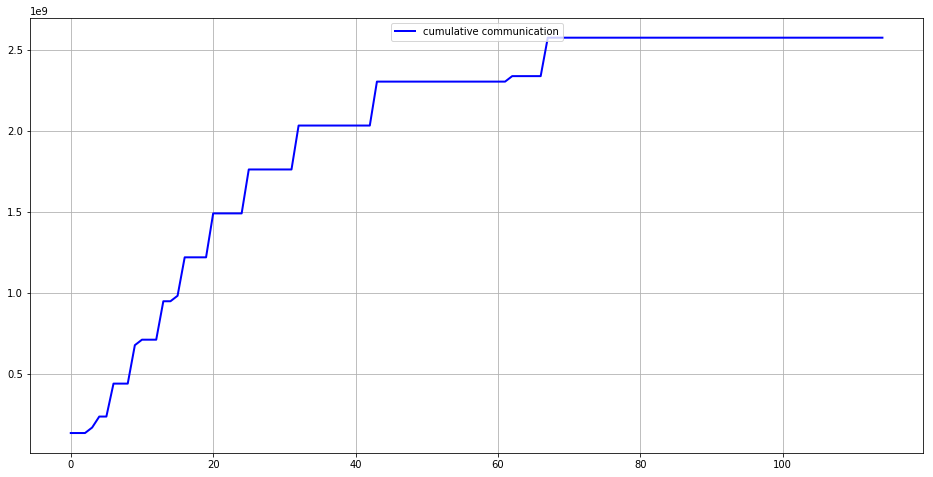

CHOSEN TIME STEP:1539340537.712
buffer [['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539340547.488\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539340855.205\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539341272.978\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539341349.130\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539341377.261\tcoordinator\tviolation\t0\t33884044\treceive\n'], ['1539341597.481\tcoordinator\tviolation\t1\t33884044\treceive\n'], ['1539342531.299\tcoordinator\tviolation\t2\t33884044\treceive\n'], ['1539342643.466\tcoordinator\tviolation\t3\t33884044\treceive\n'], ['1539342671.880\tcoordinator\tviolation\t0\t33884044\treceive\n']]
checking this line in buffer ['1539340540.679\tcoordinator\tviolation\t3\t33884044\treceive\n']
new line:  
message_sizes: [135536480, 135536480, 135536480, 169420524, 237188612, 237188612, 440492952, 440492952, 440492952, 677681336, 711565380, 711565380, 711565380, 948753764, 94

KeyboardInterrupt: 

In [74]:
files = []
timestamps = []

for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    timestamps.append([])


t = [0]
commonStep = 0
displayStep = 5
recordStep = 1
recordUnique = True

vlines_buffer = []
rlines_buffer = []
slines_buffer = []

message_size = 0
message_sizes = []

fig = plt.figure()

while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        else:
            timestamps[i].append(float(line.split('\t')[0]))
            
    currentStep = min([len(ts) for ts in timestamps]) #minimum not needed? just length of any list; because above always one timestamp gets inserted per worker
    if currentStep > commonStep: #if everywhere has been written something
        commonStep = currentStep

        # get synchr timestamp
        # MAYBE IT IS NOT NECESSARY TO CHECK ALL OF THE TIME STAMPS BUT JUST TAKE THOSE OF LAST WORKER...
        # now need to find the largest timestamp; so first of all the worker with most of the time stamps and in there the largest
        if sum(np.array([len(ts) for ts in timestamps])-max([len(ts) for ts in timestamps]))==0: #then all lengths are equal
            #print("equal lengths")
            #print(timestamps)
            time_step = float(np.amax(timestamps))
            #print("maximal time step: " + str(time_step))
        
        else:
            print("")
            print("different lengths")
            print("")
            min_length = min([len(ts) for ts in timestamps])
            # cut lists until min length and take maximal time stamp
            #print("min length: " + str(min_length)) 
            #print([ts[:min_length] for ts in timestamps])
            #print(timestamps)
            #print([ts[:min_length] for ts in timestamps])
            time_step = float(np.amax([ts[:min_length] for ts in timestamps]))
            #print("maximal time step of cut list: "+ str(time_step))


       
        # get data of registration and violation files up to this time step
        print("CHOSEN TIME STEP:" + str(time_step))
        #check for registrations up to time_step

        while True: 
            # check in buffer (if not empty)
            if rlines_buffer != []:
                for rline in rlines_buffer:
                    if float(rline[0].split("\t")[0]) <= time_step:
                        message_size = message_size + int(rline[0].split("\t")[4])
                        #print("registration message from buffer added with ts " + str(float(rline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        rlines_buffer.remove(rline)

            # read new lines
            where = data_registrations.tell()
            rline = data_registrations.readline()

            if not rline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_registrations.seek(where)
                break 
            else:
                if float(rline.split("\t")[0]) <= time_step:
                    # here: index 4 = message size
                    message_size = message_size + int(rline.split("\t")[4])
                    #print("registration message added with ts " + str(float(rline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    rlines_buffer.append([rline])
                    break


        #check for sendModels up to time_step
        while True:
            # check in buffer (if not empty)
            if slines_buffer != []:
                for sline in slines_buffer:
                    if float(sline[0].split("\t")[0]) <= time_step:
                        # count number of points in this string which coincides with the number of nodes receiving the model
                        message_size= message_size + int(sline[0].split("\t")[3])* sline[0].split("\t")[2].count(".")
                        #print("sendModel message from buffer added with ts " + str(float(sline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        slines_buffer.remove(sline)

            # read new lines
            where = data_sendModel.tell()
            sline = data_sendModel.readline()

            if not sline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_sendModel.seek(where)
                break 
            else:
                if float(sline.split("\t")[0]) <= time_step:
                    # here: index 4 = message size
                    # count number of points in this string which coincides with the number of nodes receiving the model
                    message_size= message_size + int(sline.split("\t")[3])* sline.split("\t")[2].count(".")
                    #print("sendModel message added with ts " + str(float(sline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    slines_buffer.append([sline])
                    break


        #check for violations up to time_step
        while True:
            # check in buffer (if not empty)
            print("buffer", vlines_buffer)
            #if vlines_buffer != []:
                #for vline in vlines_buffer:
                #    print("checking this line in buffer", vline)
                #    if float(vline[0].split("\t")[0]) <= time_step:
                #       message_size = message_size + int(vline[0].split("\t")[4])
                #       print("violation message from buffer added with ts " + str(float(vline[0].split("\t")[0])))
                #        print("message_size: " + str(message_size))
                #        # delete message from buffer
                #        vlines_buffer.remove(vline)
                #        print("buffer after deleting: ", vlines_buffer)

            while vlines_buffer != []: #as long as buffer is not empty
                print("checking this line in buffer", vlines_buffer[0])
                if float(vlines_buffer[0][0].split("\t")[0]) <= time_step:
                    message_size = message_size + int(vlines_buffer[0][0].split("\t")[4])
                    print("violation message from buffer added with ts " + str(float(vlines_buffer[0][0].split("\t")[0])))
                    print("message_size: " + str(message_size))
                    # delete message from buffer
                    vlines_buffer.remove(vlines_buffer[0])
                    print("buffer after deleting: ", vlines_buffer)
                else: #if first element in buffer is too big then the others in the buffer as well as first elem is smallest
                    break

            # read new lines
            where = data_violations.tell()
            vline = data_violations.readline()
            print("new line: " , vline)

            if not vline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_violations.seek(where)
                break 
            else:
                if float(vline.split("\t")[0]) <= time_step:
                    # here: index 4 = message size
                    message_size = message_size + int(vline.split("\t")[4])
                    print("violation message added with ts " + str(float(vline.split("\t")[0])))
                    print("message_size: " + str(message_size))
                else:
                    vlines_buffer.append([vline])
                    break


        message_sizes.append(message_size)
        print("message_sizes: " + str(message_sizes))

        if commonStep % displayStep == 0:


            #clear_output(wait=True)

            fig = plt.figure()
            plt.plot(t, message_sizes, lw=2, label='cumulative communication', color='blue')
            plt.legend(loc='upper center')
            plt.grid()
            plt.show()
        t.append(t[-1] + 1)
        if len(t) % recordStep == 0 and t != 0:
            j = 0
            #if recordUnique:
                #fig.savefig(os.path.join(experimentFolder, 'cumulative_communication' + str(len(t)) + '.png'), dpi=100)
            #else:
                #fig.savefig(os.path.join(experimentFolder, 'cumulative_communication.png'), dpi=100)
            j += 1


## OLD

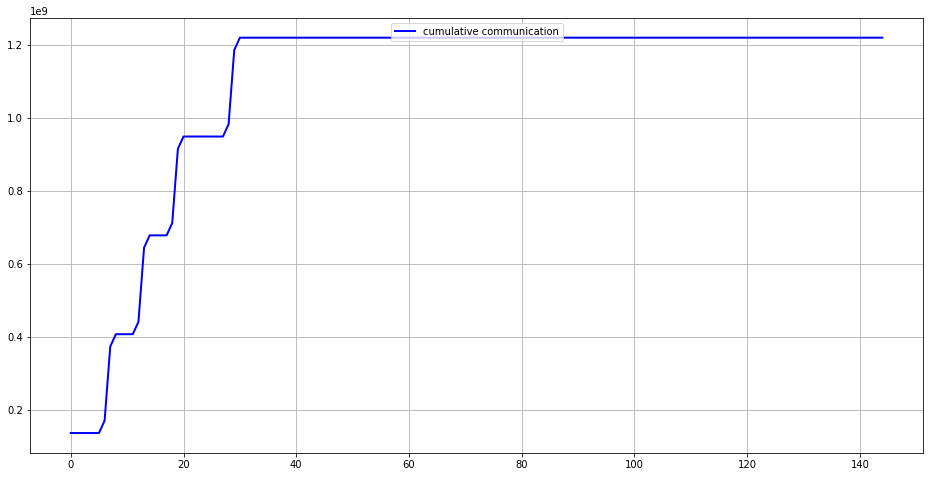

argmax[1539343806.652, 1539343812.925, 1539343819.572, 1539343825.816, 1539343832.508, 1539343838.715, 1539343844.966, 1539343851.247, 1539343858.548, 1539343864.379, 1539343870.749, 1539343877.165, 1539343883.429, 1539343889.468, 1539343896.74, 1539343902.85, 1539343908.945, 1539343915.216, 1539343921.473, 1539343927.597, 1539343933.736, 1539343941.012, 1539343946.794, 1539343952.691, 1539343958.936, 1539343965.406, 1539343971.728, 1539343977.927, 1539343984.098, 1539343990.571, 1539343996.999, 1539344003.293, 1539344009.598, 1539344028.389, 1539344029.436, 1539344030.462, 1539344036.056, 1539344042.289, 1539344048.457, 1539344054.568, 1539344060.934, 1539344067.16, 1539344073.367, 1539344079.658, 1539344086.162, 1539344092.574, 1539344098.7, 1539344104.707, 1539344110.926, 1539344117.048, 1539344123.166, 1539344129.501, 1539344135.77, 1539344142.034, 1539344148.356, 1539344154.707, 1539344160.798, 1539344166.774, 1539344172.993, 1539344179.126, 1539344185.378, 1539344191.482, 1539344

TypeError: float() argument must be a string or a number, not 'list'

In [262]:
files = []
timestamps = []

for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    timestamps.append([])


t = [0]
commonStep = 0
displayStep = 5
recordStep = 1
recordUnique = True

vlines_buffer = []
rlines_buffer = []
slines_buffer = []

message_size = 0
message_sizes = []

fig = plt.figure()

while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        else:
            timestamps[i].append(float(line.split('\t')[0]))
            
    currentStep = min([len(ts) for ts in timestamps]) #minimum not needed? just length of any list; because above always one timestamp gets inserted per worker
    if currentStep > commonStep: #if everywhere has been written something. Don't we wait above anyway such that everyone has something to plot?
        commonStep = currentStep
        
        if type(np.amax(timestamps))== list:
            print("argmax" + str(np.amax(timestamps)))
            print("timestamps" + str(timestamps))
        time_step = float(np.amax(timestamps))
        
        # get data of registration and violation files up to this time step
        #print("CHOSEN TIME STEP:" + str(time_step))

        while True: 
            # check in buffer (if not empty)
            if rlines_buffer != []:
                for rline in rlines_buffer:
                    if float(rline[0].split("\t")[0]) < time_step:
                        message_size = message_size + int(rline[0].split("\t")[4])
                        #print("registration message from buffer added with ts " + str(float(rline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        rlines_buffer.remove(rline)

            # read new lines
            where = data_registrations.tell()
            rline = data_registrations.readline()

            if not rline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_registrations.seek(where)
                break 
            else:
                if float(rline.split("\t")[0]) < time_step:
                    # here: index 4 = message size
                    message_size = message_size + int(rline.split("\t")[4])
                    #print("registration message added with ts " + str(float(rline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    rlines_buffer.append([rline])
                    break


        #check for sendModels up to time_step
        while True:
            # check in buffer (if not empty)
            if slines_buffer != []:
                for sline in slines_buffer:
                    if float(sline[0].split("\t")[0]) < time_step:
                        # count number of points in this string which coincides with the number of nodes receiving the model
                        message_size= message_size + int(sline[0].split("\t")[3])* sline[0].split("\t")[2].count(".")
                        #print("sendModel message from buffer added with ts " + str(float(sline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        slines_buffer.remove(sline)

            # read new lines
            where = data_sendModel.tell()
            sline = data_sendModel.readline()

            if not sline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_sendModel.seek(where)
                break 
            else:
                if float(sline.split("\t")[0]) < time_step:
                    # here: index 4 = message size
                    # count number of points in this string which coincides with the number of nodes receiving the model
                    message_size= message_size + int(sline.split("\t")[3])* sline.split("\t")[2].count(".")
                    #print("sendModel message added with ts " + str(float(sline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    slines_buffer.append([sline])
                    break


        #check for violations up to time_step
        while True:
            # check in buffer (if not empty)
            if vlines_buffer != []:
                for vline in vlines_buffer:
                    if float(vline[0].split("\t")[0]) < time_step:
                        message_size = message_size + int(vline[0].split("\t")[4])
                        #print("violation message from buffer added with ts " + str(float(vline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        vlines_buffer.remove(vline)

            # read new lines
            where = data_violations.tell()
            vline = data_violations.readline()

            if not vline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_violations.seek(where)
                break 
            else:
                if float(vline.split("\t")[0]) < time_step:
                    # here: index 4 = message size
                    message_size = message_size + int(vline.split("\t")[4])
                    #print("violation message added with ts " + str(float(vline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    vlines_buffer.append([vline])
                    break


        message_sizes.append(message_size)
        #print("message_sizes: " + str(message_sizes))

        if commonStep % displayStep == 0:


            clear_output(wait=True)

            fig = plt.figure()
            plt.plot(t, message_sizes, lw=2, label='cumulative communication', color='blue')
            plt.legend(loc='upper center')
            plt.grid()
            plt.show()
        t.append(t[-1] + 1)
        if len(t) % recordStep == 0 and t != 0:
            j = 0
            if recordUnique:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_communication' + str(len(t)) + '.png'), dpi=100)
            else:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_communication.png'), dpi=100)
            j += 1

In [263]:
ts = [[1539343806.652, 1539343812.847, 1539343819.346, 1539343825.397, 1539343831.715, 1539343837.967, 1539343844.19, 1539343850.423, 1539343856.422, 1539343863.308, 1539343869.481, 1539343875.663, 1539343882.009, 1539343888.307, 1539343894.505, 1539343901.488, 1539343907.72, 1539343913.827, 1539343920.114, 1539343926.423, 1539343932.638, 1539343938.873, 1539343945.885, 1539343952.147, 1539343958.442, 1539343964.822, 1539343971.053, 1539343977.184, 1539343983.303, 1539343989.544, 1539343995.69, 1539344001.867, 1539344007.992, 1539344014.123, 1539344028.389, 1539344029.341, 1539344033.626, 1539344039.913, 1539344046.111, 1539344052.302, 1539344058.663, 1539344064.805, 1539344070.965, 1539344077.201, 1539344083.482, 1539344089.662, 1539344095.908, 1539344102.257, 1539344108.387, 1539344114.703, 1539344120.914, 1539344127.106, 1539344133.268, 1539344139.434, 1539344145.614, 1539344152.012, 1539344158.125, 1539344164.437, 1539344170.915, 1539344177.116, 1539344183.136, 1539344189.207, 1539344195.278, 1539344201.424, 1539344207.704, 1539344213.885, 1539344220.115, 1539344226.34, 1539344232.602, 1539344238.755, 1539344245.066, 1539344251.171, 1539344257.414, 1539344263.577, 1539344269.74, 1539344275.996, 1539344282.205, 1539344288.433, 1539344294.664, 1539344300.851, 1539344306.976, 1539344313.168, 1539344319.228, 1539344325.412, 1539344331.612, 1539344337.799, 1539344344.087, 1539344350.344, 1539344356.635, 1539344362.875, 1539344369.176, 1539344375.356, 1539344381.63, 1539344387.763, 1539344394.126, 1539344400.333, 1539344406.515, 1539344412.625, 1539344418.836, 1539344425.013, 1539344431.124, 1539344437.392, 1539344443.627, 1539344450.049, 1539344456.154, 1539344462.299, 1539344468.676, 1539344474.73, 1539344480.79, 1539344487.203, 1539344493.393, 1539344499.667, 1539344506.033, 1539344512.226, 1539344518.561, 1539344524.825, 1539344530.905, 1539344536.967, 1539344543.049, 1539344549.218, 1539344555.348, 1539344561.624, 1539344567.85, 1539344574.047, 1539344580.119, 1539344586.298, 1539344592.512, 1539344598.719, 1539344604.924, 1539344611.083, 1539344617.327, 1539344623.623, 1539344629.892, 1539344635.978, 1539344642.194, 1539344648.407, 1539344654.533, 1539344660.896, 1539344667.043, 1539344673.328, 1539344679.491, 1539344685.977, 1539344692.444, 1539344698.847, 1539344705.745, 1539344712.12, 1539344718.457, 1539344724.761], [1539343802.776, 1539343808.776, 1539343814.743, 1539343821.31, 1539343827.511, 1539343833.911, 1539343840.227, 1539343858.692, 1539343859.699, 1539343860.606, 1539343865.709, 1539343872.145, 1539343878.373, 1539343896.72, 1539343897.667, 1539343898.601, 1539343904.419, 1539343910.416, 1539343916.445, 1539343941.047, 1539343941.963, 1539343942.91, 1539343943.829, 1539343948.49, 1539343954.778, 1539343961.274, 1539343967.577, 1539343973.53, 1539343979.78, 1539344028.332, 1539344029.214, 1539344030.243, 1539344031.21, 1539344032.172, 1539344033.081, 1539344034.018, 1539344035.058, 1539344036.464, 1539344042.64, 1539344048.996, 1539344055.146, 1539344061.469, 1539344067.597, 1539344073.489, 1539344079.526, 1539344086.053, 1539344092.433, 1539344098.794, 1539344105.146, 1539344111.361, 1539344117.551, 1539344123.878, 1539344130.147, 1539344136.519, 1539344142.774, 1539344148.997, 1539344155.32, 1539344161.681, 1539344168.107, 1539344174.323, 1539344180.438, 1539344186.572, 1539344192.764, 1539344198.814, 1539344204.892, 1539344210.8, 1539344216.884, 1539344223.145, 1539344229.432, 1539344235.76, 1539344242.043, 1539344248.224, 1539344254.191, 1539344260.567, 1539344266.705, 1539344272.663, 1539344278.879, 1539344285.21, 1539344291.466, 1539344297.713, 1539344303.912, 1539344310.155, 1539344316.099, 1539344322.271, 1539344328.374, 1539344334.571, 1539344340.724, 1539344346.879, 1539344352.859, 1539344359.317, 1539344365.683, 1539344371.813, 1539344377.99, 1539344384.034, 1539344390.232, 1539344396.609, 1539344402.958, 1539344409.166, 1539344415.388, 1539344421.57, 1539344427.814, 1539344433.956, 1539344439.895, 1539344446.497, 1539344452.689, 1539344458.751, 1539344464.86, 1539344470.89, 1539344477.088, 1539344483.21, 1539344489.591, 1539344495.869, 1539344502.167, 1539344508.397, 1539344514.842, 1539344521.102, 1539344527.428, 1539344533.794, 1539344539.841, 1539344545.951, 1539344551.868, 1539344557.88, 1539344563.853, 1539344569.848, 1539344575.927, 1539344582.033, 1539344588.302, 1539344594.56, 1539344600.871, 1539344607.028, 1539344612.978, 1539344619.054, 1539344625.25, 1539344631.482, 1539344637.699, 1539344643.754, 1539344650.015, 1539344655.998, 1539344662.15, 1539344668.282, 1539344674.28, 1539344680.599, 1539344686.686, 1539344693.01, 1539344699.238, 1539344705.961, 1539344712.556, 1539344719.062, 1539344725.545], [1539343806.466, 1539343812.594, 1539343818.924, 1539343825.291, 1539343831.38, 1539343837.705, 1539343843.818, 1539343850.144, 1539343858.679, 1539343863.581, 1539343869.854, 1539343876.07, 1539343882.165, 1539343888.192, 1539343894.395, 1539343901.457, 1539343907.814, 1539343914.081, 1539343920.345, 1539343926.324, 1539343932.271, 1539343938.569, 1539343945.669, 1539343951.841, 1539343958.01, 1539343964.344, 1539343970.642, 1539343976.978, 1539343983.401, 1539343989.434, 1539343995.577, 1539344001.684, 1539344007.812, 1539344013.936, 1539344020.044, 1539344026.034, 1539344033.44, 1539344039.796, 1539344045.978, 1539344052.098, 1539344058.418, 1539344064.689, 1539344070.81, 1539344076.942, 1539344082.982, 1539344089.336, 1539344095.356, 1539344102.04, 1539344108.156, 1539344114.186, 1539344120.388, 1539344126.61, 1539344132.871, 1539344139.059, 1539344145.493, 1539344151.907, 1539344158.223, 1539344164.359, 1539344170.768, 1539344177.104, 1539344183.307, 1539344189.446, 1539344195.466, 1539344201.66, 1539344207.818, 1539344214.055, 1539344220.36, 1539344226.591, 1539344232.837, 1539344239.16, 1539344245.489, 1539344251.71, 1539344257.897, 1539344264.034, 1539344270.111, 1539344276.298, 1539344282.61, 1539344288.859, 1539344294.908, 1539344301.504, 1539344307.765, 1539344313.868, 1539344320.187, 1539344326.411, 1539344332.577, 1539344338.578, 1539344344.8, 1539344351.035, 1539344357.209, 1539344363.415, 1539344369.758, 1539344375.884, 1539344382.049, 1539344388.216, 1539344394.291, 1539344400.498, 1539344406.857, 1539344413.102, 1539344419.242, 1539344425.292, 1539344431.318, 1539344437.555, 1539344443.787, 1539344449.965, 1539344456.037, 1539344462.192, 1539344468.415, 1539344474.553, 1539344480.872, 1539344486.973, 1539344493.307, 1539344499.56, 1539344505.798, 1539344512.034, 1539344518.203, 1539344524.314, 1539344530.377, 1539344536.567, 1539344542.774, 1539344549.003, 1539344555.249, 1539344561.492, 1539344567.593, 1539344573.742, 1539344580.02, 1539344586.047, 1539344592.341, 1539344598.466, 1539344604.658, 1539344610.763, 1539344616.883, 1539344622.999, 1539344629.085, 1539344635.245, 1539344641.447, 1539344647.471, 1539344653.756, 1539344659.806, 1539344666.051, 1539344672.142, 1539344678.282, 1539344684.308, 1539344690.537, 1539344696.797, 1539344703.116, 1539344709.736, 1539344716.096, 1539344722.665, 1539344729.096], [1539343806.652, 1539343812.925, 1539343819.572, 1539343825.816, 1539343832.508, 1539343838.715, 1539343844.966, 1539343851.247, 1539343858.548, 1539343864.379, 1539343870.749, 1539343877.165, 1539343883.429, 1539343889.468, 1539343896.74, 1539343902.85, 1539343908.945, 1539343915.216, 1539343921.473, 1539343927.597, 1539343933.736, 1539343941.012, 1539343946.794, 1539343952.691, 1539343958.936, 1539343965.406, 1539343971.728, 1539343977.927, 1539343984.098, 1539343990.571, 1539343996.999, 1539344003.293, 1539344009.598, 1539344028.389, 1539344029.436, 1539344030.462, 1539344036.056, 1539344042.289, 1539344048.457, 1539344054.568, 1539344060.934, 1539344067.16, 1539344073.367, 1539344079.658, 1539344086.162, 1539344092.574, 1539344098.7, 1539344104.707, 1539344110.926, 1539344117.048, 1539344123.166, 1539344129.501, 1539344135.77, 1539344142.034, 1539344148.356, 1539344154.707, 1539344160.798, 1539344166.774, 1539344172.993, 1539344179.126, 1539344185.378, 1539344191.482, 1539344197.642, 1539344203.9, 1539344210.317, 1539344216.777, 1539344222.842, 1539344229.191, 1539344235.627, 1539344242.129, 1539344248.443, 1539344254.819, 1539344260.926, 1539344266.979, 1539344272.995, 1539344279.166, 1539344285.497, 1539344291.759, 1539344298.02, 1539344304.235, 1539344310.294, 1539344316.345, 1539344322.554, 1539344328.802, 1539344335.031, 1539344341.3, 1539344347.38, 1539344353.634, 1539344359.995, 1539344366.242, 1539344372.598, 1539344378.836, 1539344385.118, 1539344391.38, 1539344397.669, 1539344404.066, 1539344410.225, 1539344416.176, 1539344422.21, 1539344428.357, 1539344434.522, 1539344440.548, 1539344446.391, 1539344452.471, 1539344458.54, 1539344464.923, 1539344471.291, 1539344477.435, 1539344483.608, 1539344490.024, 1539344496.273, 1539344502.626, 1539344509.011, 1539344515.418, 1539344521.522, 1539344527.88, 1539344534.039, 1539344540.393, 1539344546.724, 1539344553.07, 1539344559.493, 1539344565.893, 1539344572.244, 1539344578.515, 1539344584.661, 1539344591.042, 1539344597.115, 1539344603.136, 1539344609.2, 1539344615.479, 1539344621.769, 1539344627.925, 1539344634.231, 1539344640.505, 1539344646.715, 1539344653.187, 1539344659.418, 1539344665.656, 1539344671.942, 1539344678.078, 1539344684.431, 1539344690.792, 1539344697.184, 1539344703.567, 1539344710.123, 1539344716.594, 1539344722.998, 1539344729.236]]

In [265]:
len(ts)

4

In [306]:
np.array([np.array(elem) for elem in ts]).flatten()

array([array([1.53934381e+09, 1.53934381e+09, 1.53934382e+09, 1.53934383e+09,
       1.53934383e+09, 1.53934384e+09, 1.53934384e+09, 1.53934385e+09,
       1.53934386e+09, 1.53934386e+09, 1.53934387e+09, 1.53934388e+09,
       1.53934388e+09, 1.53934389e+09, 1.53934389e+09, 1.53934390e+09,
       1.53934391e+09, 1.53934391e+09, 1.53934392e+09, 1.53934393e+09,
       1.53934393e+09, 1.53934394e+09, 1.53934395e+09, 1.53934395e+09,
       1.53934396e+09, 1.53934396e+09, 1.53934397e+09, 1.53934398e+09,
       1.53934398e+09, 1.53934399e+09, 1.53934400e+09, 1.53934400e+09,
       1.53934401e+09, 1.53934401e+09, 1.53934403e+09, 1.53934403e+09,
       1.53934403e+09, 1.53934404e+09, 1.53934405e+09, 1.53934405e+09,
       1.53934406e+09, 1.53934406e+09, 1.53934407e+09, 1.53934408e+09,
       1.53934408e+09, 1.53934409e+09, 1.53934410e+09, 1.53934410e+09,
       1.53934411e+09, 1.53934411e+09, 1.53934412e+09, 1.53934413e+09,
       1.53934413e+09, 1.53934414e+09, 1.53934415e+09, 1.53934415e+09,

In [296]:
np.array([]).flatten()

array([list([1539343806.652, 1539343812.847, 1539343819.346, 1539343825.397, 1539343831.715, 1539343837.967, 1539343844.19, 1539343850.423, 1539343856.422, 1539343863.308, 1539343869.481, 1539343875.663, 1539343882.009, 1539343888.307, 1539343894.505, 1539343901.488, 1539343907.72, 1539343913.827, 1539343920.114, 1539343926.423, 1539343932.638, 1539343938.873, 1539343945.885, 1539343952.147, 1539343958.442, 1539343964.822, 1539343971.053, 1539343977.184, 1539343983.303, 1539343989.544, 1539343995.69, 1539344001.867, 1539344007.992, 1539344014.123, 1539344028.389, 1539344029.341, 1539344033.626, 1539344039.913, 1539344046.111, 1539344052.302, 1539344058.663, 1539344064.805, 1539344070.965, 1539344077.201, 1539344083.482, 1539344089.662, 1539344095.908, 1539344102.257, 1539344108.387, 1539344114.703, 1539344120.914, 1539344127.106, 1539344133.268, 1539344139.434, 1539344145.614, 1539344152.012, 1539344158.125, 1539344164.437, 1539344170.915, 1539344177.116, 1539344183.136, 1539344189.207

In [ ]:
np.array(ts).flatten

In [291]:
max()1

[1539343806.652,
 1539343812.925,
 1539343819.572,
 1539343825.816,
 1539343832.508,
 1539343838.715,
 1539343844.966,
 1539343851.247,
 1539343858.548,
 1539343864.379,
 1539343870.749,
 1539343877.165,
 1539343883.429,
 1539343889.468,
 1539343896.74,
 1539343902.85,
 1539343908.945,
 1539343915.216,
 1539343921.473,
 1539343927.597,
 1539343933.736,
 1539343941.012,
 1539343946.794,
 1539343952.691,
 1539343958.936,
 1539343965.406,
 1539343971.728,
 1539343977.927,
 1539343984.098,
 1539343990.571,
 1539343996.999,
 1539344003.293,
 1539344009.598,
 1539344028.389,
 1539344029.436,
 1539344030.462,
 1539344036.056,
 1539344042.289,
 1539344048.457,
 1539344054.568,
 1539344060.934,
 1539344067.16,
 1539344073.367,
 1539344079.658,
 1539344086.162,
 1539344092.574,
 1539344098.7,
 1539344104.707,
 1539344110.926,
 1539344117.048,
 1539344123.166,
 1539344129.501,
 1539344135.77,
 1539344142.034,
 1539344148.356,
 1539344154.707,
 1539344160.798,
 1539344166.774,
 1539344172.993,
 15

In [278]:
np.amax(ts)

[1539343806.652,
 1539343812.925,
 1539343819.572,
 1539343825.816,
 1539343832.508,
 1539343838.715,
 1539343844.966,
 1539343851.247,
 1539343858.548,
 1539343864.379,
 1539343870.749,
 1539343877.165,
 1539343883.429,
 1539343889.468,
 1539343896.74,
 1539343902.85,
 1539343908.945,
 1539343915.216,
 1539343921.473,
 1539343927.597,
 1539343933.736,
 1539343941.012,
 1539343946.794,
 1539343952.691,
 1539343958.936,
 1539343965.406,
 1539343971.728,
 1539343977.927,
 1539343984.098,
 1539343990.571,
 1539343996.999,
 1539344003.293,
 1539344009.598,
 1539344028.389,
 1539344029.436,
 1539344030.462,
 1539344036.056,
 1539344042.289,
 1539344048.457,
 1539344054.568,
 1539344060.934,
 1539344067.16,
 1539344073.367,
 1539344079.658,
 1539344086.162,
 1539344092.574,
 1539344098.7,
 1539344104.707,
 1539344110.926,
 1539344117.048,
 1539344123.166,
 1539344129.501,
 1539344135.77,
 1539344142.034,
 1539344148.356,
 1539344154.707,
 1539344160.798,
 1539344166.774,
 1539344172.993,
 15

In [ ]:
TypeError                                 Traceback (most recent call last)
<ipython-input-243-1167ee3da39d> in <module>()
     37         commonStep = currentStep
     38 
---> 39         time_step = float(np.amax(timestamps))
     40 
     41         # get data of registration and violation files up to this time step

TypeError: float() argument must be a string or a number, not 'list'

In [ ]:
[[1539343806.652, 1539343812.847, 1539343819.346, 1539343825.397, 1539343831.715, 1539343837.967, 1539343844.19, 1539343850.423, 1539343856.422, 1539343863.308, 1539343869.481, 1539343875.663, 1539343882.009, 1539343888.307, 1539343894.505, 1539343901.488, 1539343907.72, 1539343913.827, 1539343920.114, 1539343926.423, 1539343932.638, 1539343938.873, 1539343945.885, 1539343952.147, 1539343958.442, 1539343964.822, 1539343971.053, 1539343977.184, 1539343983.303, 1539343989.544, 1539343995.69, 1539344001.867, 1539344007.992, 1539344014.123, 1539344028.389, 1539344029.341, 1539344033.626, 1539344039.913, 1539344046.111, 1539344052.302, 1539344058.663, 1539344064.805, 1539344070.965, 1539344077.201, 1539344083.482, 1539344089.662, 1539344095.908, 1539344102.257, 1539344108.387, 1539344114.703, 1539344120.914, 1539344127.106, 1539344133.268, 1539344139.434, 1539344145.614, 1539344152.012, 1539344158.125, 1539344164.437, 1539344170.915, 1539344177.116, 1539344183.136, 1539344189.207, 1539344195.278, 1539344201.424, 1539344207.704, 1539344213.885, 1539344220.115, 1539344226.34, 1539344232.602, 1539344238.755, 1539344245.066, 1539344251.171, 1539344257.414, 1539344263.577, 1539344269.74, 1539344275.996, 1539344282.205, 1539344288.433, 1539344294.664, 1539344300.851, 1539344306.976, 1539344313.168, 1539344319.228, 1539344325.412, 1539344331.612, 1539344337.799, 1539344344.087, 1539344350.344, 1539344356.635, 1539344362.875, 1539344369.176, 1539344375.356, 1539344381.63, 1539344387.763, 1539344394.126, 1539344400.333, 1539344406.515, 1539344412.625, 1539344418.836, 1539344425.013, 1539344431.124, 1539344437.392, 1539344443.627, 1539344450.049, 1539344456.154, 1539344462.299, 1539344468.676, 1539344474.73, 1539344480.79, 1539344487.203, 1539344493.393, 1539344499.667, 1539344506.033, 1539344512.226, 1539344518.561, 1539344524.825, 1539344530.905, 1539344536.967, 1539344543.049, 1539344549.218, 1539344555.348, 1539344561.624, 1539344567.85, 1539344574.047, 1539344580.119, 1539344586.298, 1539344592.512, 1539344598.719, 1539344604.924, 1539344611.083, 1539344617.327, 1539344623.623, 1539344629.892, 1539344635.978, 1539344642.194, 1539344648.407, 1539344654.533, 1539344660.896, 1539344667.043, 1539344673.328, 1539344679.491, 1539344685.977, 1539344692.444, 1539344698.847, 1539344705.745, 1539344712.12, 1539344718.457, 1539344724.761], [1539343802.776, 1539343808.776, 1539343814.743, 1539343821.31, 1539343827.511, 1539343833.911, 1539343840.227, 1539343858.692, 1539343859.699, 1539343860.606, 1539343865.709, 1539343872.145, 1539343878.373, 1539343896.72, 1539343897.667, 1539343898.601, 1539343904.419, 1539343910.416, 1539343916.445, 1539343941.047, 1539343941.963, 1539343942.91, 1539343943.829, 1539343948.49, 1539343954.778, 1539343961.274, 1539343967.577, 1539343973.53, 1539343979.78, 1539344028.332, 1539344029.214, 1539344030.243, 1539344031.21, 1539344032.172, 1539344033.081, 1539344034.018, 1539344035.058, 1539344036.464, 1539344042.64, 1539344048.996, 1539344055.146, 1539344061.469, 1539344067.597, 1539344073.489, 1539344079.526, 1539344086.053, 1539344092.433, 1539344098.794, 1539344105.146, 1539344111.361, 1539344117.551, 1539344123.878, 1539344130.147, 1539344136.519, 1539344142.774, 1539344148.997, 1539344155.32, 1539344161.681, 1539344168.107, 1539344174.323, 1539344180.438, 1539344186.572, 1539344192.764, 1539344198.814, 1539344204.892, 1539344210.8, 1539344216.884, 1539344223.145, 1539344229.432, 1539344235.76, 1539344242.043, 1539344248.224, 1539344254.191, 1539344260.567, 1539344266.705, 1539344272.663, 1539344278.879, 1539344285.21, 1539344291.466, 1539344297.713, 1539344303.912, 1539344310.155, 1539344316.099, 1539344322.271, 1539344328.374, 1539344334.571, 1539344340.724, 1539344346.879, 1539344352.859, 1539344359.317, 1539344365.683, 1539344371.813, 1539344377.99, 1539344384.034, 1539344390.232, 1539344396.609, 1539344402.958, 1539344409.166, 1539344415.388, 1539344421.57, 1539344427.814, 1539344433.956, 1539344439.895, 1539344446.497, 1539344452.689, 1539344458.751, 1539344464.86, 1539344470.89, 1539344477.088, 1539344483.21, 1539344489.591, 1539344495.869, 1539344502.167, 1539344508.397, 1539344514.842, 1539344521.102, 1539344527.428, 1539344533.794, 1539344539.841, 1539344545.951, 1539344551.868, 1539344557.88, 1539344563.853, 1539344569.848, 1539344575.927, 1539344582.033, 1539344588.302, 1539344594.56, 1539344600.871, 1539344607.028, 1539344612.978, 1539344619.054, 1539344625.25, 1539344631.482, 1539344637.699, 1539344643.754, 1539344650.015, 1539344655.998, 1539344662.15, 1539344668.282, 1539344674.28, 1539344680.599, 1539344686.686, 1539344693.01, 1539344699.238, 1539344705.961, 1539344712.556, 1539344719.062, 1539344725.545], [1539343806.466, 1539343812.594, 1539343818.924, 1539343825.291, 1539343831.38, 1539343837.705, 1539343843.818, 1539343850.144, 1539343858.679, 1539343863.581, 1539343869.854, 1539343876.07, 1539343882.165, 1539343888.192, 1539343894.395, 1539343901.457, 1539343907.814, 1539343914.081, 1539343920.345, 1539343926.324, 1539343932.271, 1539343938.569, 1539343945.669, 1539343951.841, 1539343958.01, 1539343964.344, 1539343970.642, 1539343976.978, 1539343983.401, 1539343989.434, 1539343995.577, 1539344001.684, 1539344007.812, 1539344013.936, 1539344020.044, 1539344026.034, 1539344033.44, 1539344039.796, 1539344045.978, 1539344052.098, 1539344058.418, 1539344064.689, 1539344070.81, 1539344076.942, 1539344082.982, 1539344089.336, 1539344095.356, 1539344102.04, 1539344108.156, 1539344114.186, 1539344120.388, 1539344126.61, 1539344132.871, 1539344139.059, 1539344145.493, 1539344151.907, 1539344158.223, 1539344164.359, 1539344170.768, 1539344177.104, 1539344183.307, 1539344189.446, 1539344195.466, 1539344201.66, 1539344207.818, 1539344214.055, 1539344220.36, 1539344226.591, 1539344232.837, 1539344239.16, 1539344245.489, 1539344251.71, 1539344257.897, 1539344264.034, 1539344270.111, 1539344276.298, 1539344282.61, 1539344288.859, 1539344294.908, 1539344301.504, 1539344307.765, 1539344313.868, 1539344320.187, 1539344326.411, 1539344332.577, 1539344338.578, 1539344344.8, 1539344351.035, 1539344357.209, 1539344363.415, 1539344369.758, 1539344375.884, 1539344382.049, 1539344388.216, 1539344394.291, 1539344400.498, 1539344406.857, 1539344413.102, 1539344419.242, 1539344425.292, 1539344431.318, 1539344437.555, 1539344443.787, 1539344449.965, 1539344456.037, 1539344462.192, 1539344468.415, 1539344474.553, 1539344480.872, 1539344486.973, 1539344493.307, 1539344499.56, 1539344505.798, 1539344512.034, 1539344518.203, 1539344524.314, 1539344530.377, 1539344536.567, 1539344542.774, 1539344549.003, 1539344555.249, 1539344561.492, 1539344567.593, 1539344573.742, 1539344580.02, 1539344586.047, 1539344592.341, 1539344598.466, 1539344604.658, 1539344610.763, 1539344616.883, 1539344622.999, 1539344629.085, 1539344635.245, 1539344641.447, 1539344647.471, 1539344653.756, 1539344659.806, 1539344666.051, 1539344672.142, 1539344678.282, 1539344684.308, 1539344690.537, 1539344696.797, 1539344703.116, 1539344709.736, 1539344716.096, 1539344722.665, 1539344729.096], [1539343806.652, 1539343812.925, 1539343819.572, 1539343825.816, 1539343832.508, 1539343838.715, 1539343844.966, 1539343851.247, 1539343858.548, 1539343864.379, 1539343870.749, 1539343877.165, 1539343883.429, 1539343889.468, 1539343896.74, 1539343902.85, 1539343908.945, 1539343915.216, 1539343921.473, 1539343927.597, 1539343933.736, 1539343941.012, 1539343946.794, 1539343952.691, 1539343958.936, 1539343965.406, 1539343971.728, 1539343977.927, 1539343984.098, 1539343990.571, 1539343996.999, 1539344003.293, 1539344009.598, 1539344028.389, 1539344029.436, 1539344030.462, 1539344036.056, 1539344042.289, 1539344048.457, 1539344054.568, 1539344060.934, 1539344067.16, 1539344073.367, 1539344079.658, 1539344086.162, 1539344092.574, 1539344098.7, 1539344104.707, 1539344110.926, 1539344117.048, 1539344123.166, 1539344129.501, 1539344135.77, 1539344142.034, 1539344148.356, 1539344154.707, 1539344160.798, 1539344166.774, 1539344172.993, 1539344179.126, 1539344185.378, 1539344191.482, 1539344197.642, 1539344203.9, 1539344210.317, 1539344216.777, 1539344222.842, 1539344229.191, 1539344235.627, 1539344242.129, 1539344248.443, 1539344254.819, 1539344260.926, 1539344266.979, 1539344272.995, 1539344279.166, 1539344285.497, 1539344291.759, 1539344298.02, 1539344304.235, 1539344310.294, 1539344316.345, 1539344322.554, 1539344328.802, 1539344335.031, 1539344341.3, 1539344347.38, 1539344353.634, 1539344359.995, 1539344366.242, 1539344372.598, 1539344378.836, 1539344385.118, 1539344391.38, 1539344397.669, 1539344404.066, 1539344410.225, 1539344416.176, 1539344422.21, 1539344428.357, 1539344434.522, 1539344440.548, 1539344446.391, 1539344452.471, 1539344458.54, 1539344464.923, 1539344471.291, 1539344477.435, 1539344483.608, 1539344490.024, 1539344496.273, 1539344502.626, 1539344509.011, 1539344515.418, 1539344521.522, 1539344527.88, 1539344534.039, 1539344540.393, 1539344546.724, 1539344553.07, 1539344559.493, 1539344565.893, 1539344572.244, 1539344578.515, 1539344584.661, 1539344591.042, 1539344597.115, 1539344603.136, 1539344609.2, 1539344615.479, 1539344621.769, 1539344627.925, 1539344634.231, 1539344640.505, 1539344646.715, 1539344653.187, 1539344659.418, 1539344665.656, 1539344671.942, 1539344678.078, 1539344684.431, 1539344690.792, 1539344697.184, 1539344703.567, 1539344710.123, 1539344716.594, 1539344722.998, 1539344729.236]]


























# Somehow changed

In [ ]:
files = []
losses = []
timestamps = []
for i in range(nodesAmount):
    files.append(open(os.path.join(experimentFolder, "worker" + str(i), "losses.txt"), "r"))
    losses.append([])
    timestamps.append([])



t = [0]
commonStep = 0

displayStep = 5
recordStep = 1
recordUnique = True



#print(f"message_sizes after registration {message_sizes}")
# buffer for violation messages (lines get read but might not be relevant for that sync round; so we have to remember them for the next time)

vlines_buffer = []
rlines_buffer = []
slines_buffer = []

message_size = 0
message_sizes = []



#figs = []
while 1:
    for i in range(nodesAmount):
        file = files[i]
        where = file.tell()
        line = file.readline()
        if not line:
            time.sleep(1)
            file.seek(where)
        else:
            losses[i].append(float(line[:-1].split('\t')[1])) #could append sth else or take a counter
            timestamps[i].append(float(line.split('\t')[0]))
            
    currentStep = min([len(l) for l in losses])
    # now need to know which worker is responsible for the minimum and take time stamp of this
    worker_ind = np.argmin([len(l) for l in losses])
    #now take time stamp of this worker
    
    #for i in range(nodesAmount):
    #file = worker0_losses
    sync_file = files[worker_ind]
    where = sync_file.tell()
    line = sync_file.readline()
    if not line:
        time.sleep(1)
        sync_file.seek(where)
    else:
        losses.append(float(line[:-1].split('\t')[1])) # unnecessary here but just leave it for the moment to ensure running of the code below
        
        
        time_step = float(line.split('\t')[0])
        # get data of registration and violation files up to this time step
        #print("TIME STEP:" + str(time_step))
        #check for registrations up to time_step
        
        while True:  #unnecessary overhead, but just copied. Could restrict it to number of learners etc.
            # check in buffer (if not empty)
            if rlines_buffer != []:
                for rline in rlines_buffer:
                    if float(rline[0].split("\t")[0]) < time_step:
                        message_size = message_size + int(rline[0].split("\t")[4])
                        #print("registration message from buffer added with ts " + str(float(rline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        rlines_buffer.remove(rline)


            # read new lines
            where = data_registrations.tell()
            rline = data_registrations.readline()

            if not rline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_registrations.seek(where)
                break 
            else:
                if float(rline.split("\t")[0]) < time_step:
                    # here: index 4 = message size
                    message_size = message_size + int(rline.split("\t")[4])
                    #print("registration message added with ts " + str(float(rline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    rlines_buffer.append([rline])
                    break
        

        
        #check for sendModels up to time_step
        while True:
            # check in buffer (if not empty)
            if slines_buffer != []:
                for sline in slines_buffer:
                    if float(sline[0].split("\t")[0]) < time_step:
                        # count number of points in this string which coincides with the number of nodes receiving the model
                        message_size= message_size + int(sline[0].split("\t")[3])* sline[0].split("\t")[2].count(".")
                        #print("sendModel message from buffer added with ts " + str(float(sline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        slines_buffer.remove(sline)


            # read new lines
            where = data_sendModel.tell()
            sline = data_sendModel.readline()

            if not sline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_sendModel.seek(where)
                break 
            else:
                if float(sline.split("\t")[0]) < time_step:
                    # here: index 4 = message size
                    # count number of points in this string which coincides with the number of nodes receiving the model
                    message_size= message_size + int(sline.split("\t")[3])* sline.split("\t")[2].count(".")
                    #print("sendModel message added with ts " + str(float(sline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    slines_buffer.append([sline])
                    break
        
        
        
        
        
        
        
        
        
        #check for violations up to time_step
        while True:
            # check in buffer (if not empty)
            if vlines_buffer != []:
                for vline in vlines_buffer:
                    if float(vline[0].split("\t")[0]) < time_step:
                        message_size = message_size + int(vline[0].split("\t")[4])
                        #print("violation message from buffer added with ts " + str(float(vline[0].split("\t")[0])))
                        #print("message_size: " + str(message_size))
                        # delete message from buffer
                        vlines_buffer.remove(vline)


            # read new lines
            where = data_violations.tell()
            vline = data_violations.readline()

            if not vline:    #could it be that I'M waiting here too long?
                #time.sleep(1)
                data_violations.seek(where)
                break 
            else:
                if float(vline.split("\t")[0]) < time_step:
                    # here: index 4 = message size
                    message_size = message_size + int(vline.split("\t")[4])
                    #print("violation message added with ts " + str(float(vline.split("\t")[0])))
                    #print("message_size: " + str(message_size))
                else:
                    vlines_buffer.append([vline])
                    break
        
        
        message_sizes.append(message_size)
        #print("message_sizes: " + str(message_sizes))
        
           
    #currentStep = min([len(l) for l in losses])
    #currentStep = len(losses)
    if currentStep > commonStep:
        commonStep = currentStep
        if commonStep % displayStep == 0:
            
            
            clear_output(wait=True)
            
            
            
            #cutLosses = [l[:commonStep] for l in losses]
            #figs = []
            #for i in range(nodesAmount):
            #figs.append(plt.figure())
            plt.figure()
            #plt.plot(t, cutLosses[i], lw=2, label='loss learner ' + str(i), color='red')
            plt.plot(t, message_sizes, lw=2, label='cumulative communication', color='blue')
            plt.legend(loc='upper center')
            plt.grid()
            plt.show()
        t.append(t[-1] + 1)
        if len(t) % recordStep == 0 and t != 0:
            j = 0
            #for fig in figs:
            if recordUnique:
                #fig.savefig(os.path.join(experimentFolder, 'loss_learner' + str(j) + '_' + str(len(t)) + '.png'), dpi=100)
                fig.savefig(os.path.join(experimentFolder, 'cumulative_communication' + str(len(t)) + '.png'), dpi=100)
            else:
                #fig.savefig(os.path.join(experimentFolder, 'loss_learner' + str(j) + '.png'), dpi=100)
                fig.savefig(os.path.join(experimentFolder, 'cumulative_communication.png'), dpi=100)
            j += 1
            
            
            
            


# OLD

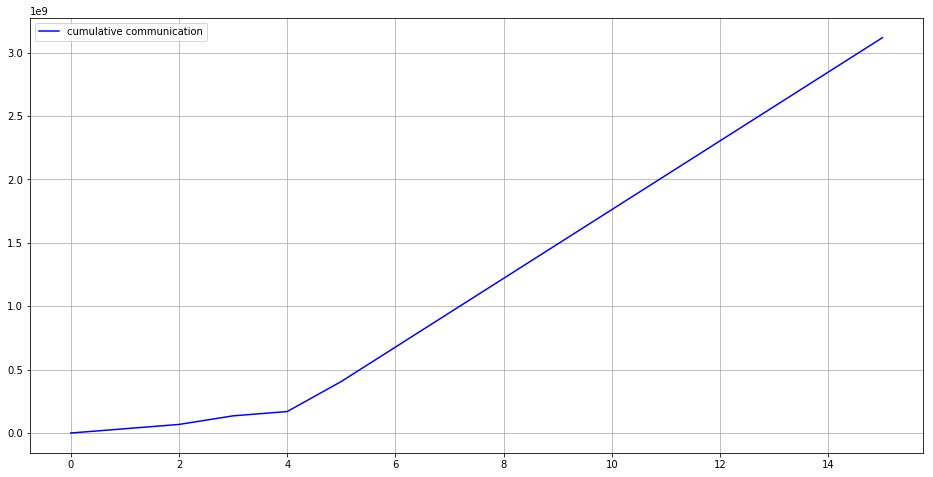

KeyboardInterrupt: 

In [67]:
# registration messages sizes

displayStep = 1
recordStep = 1
recordUnique = True


reg_msizes = []
line = data_registrations.readline()


while line != "":
    # here: index 4 = message size
    reg_msizes.append(int(line.split("\t")[4]))
    line = data_registrations.readline()

# initial value of message_sizes = sum of registration message sizes    
message_size = sum(reg_msizes)
message_sizes = []
message_sizes.append(message_size)

#print(f"message_sizes after registration {message_sizes}")
# buffer for violation messages (lines get read but might not be relevant for that sync round; so we have to remember them for the next time)

vlines_buffer = []


sync_round = 0
sync_rounds = []

sync_rounds.append(sync_round)



count = 0


    
while True:
    #print(f"message_sizes beginning first loop {message_sizes}")
    where = data_sendModel.tell()
    line = data_sendModel.readline()
    if not line:
        time.sleep(1)
        data_sendModel.seek(where)
    else:
        sync_round = sync_round + 1
        sync_rounds.append(sync_round)
        # index 0 = time stamp
        sync_time = float(line.split("\t")[0])
        # here: index 3 = message size, index 2 = topic which contains nodes that the model is sent to
        # count number of points in this string which coincides with the number of nodes receiving the model
        message_size= message_size + int(line.split("\t")[3])* line.split("\t")[2].count(".")
        #print(f"message_sizes after sync {message_sizes}")

        # now check for violation messages up to sync time
        while True:

            # check in buffer (if not empty)
            if vlines_buffer != []:
                for vline in vlines_buffer:
                    if float(vline[0].split("\t")[0]) < sync_time:
                        message_size = message_size + int(vline[0].split("\t")[4])
                        # delete message from buffer
                        vlines_buffer.remove(vline)
            
            
            # read new lines
            where = data_violations.tell()
            vline = data_violations.readline()

            if not vline:
                time.sleep(1)
                data_violations.seek(where)
            else:
                if float(vline.split("\t")[0]) < sync_time:
                    # if violation message was before synchronizing, add size of this message 
                    # here: index 4 = message size
                    message_size = message_size + int(vline.split("\t")[4])
                else:
                    vlines_buffer.append([vline])
                    break

        
        message_sizes.append(message_size)
        
        if sync_round % displayStep == 0:
            clear_output(wait=True)
            fig = plt.figure()
            plt.plot(sync_rounds, message_sizes, label='cumulative communication', color='blue')
            plt.legend(loc='upper left')
            plt.grid()
            plt.show()
        if sync_round % recordStep == 0:
            if recordUnique:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_communication' + str(sync_round) + '.png'), dpi=100)
            else:
                fig.savefig(os.path.join(experimentFolder, 'cumulative_communication.png'), dpi=100)

In [29]:
for file in files:
    file.close()

In [37]:
#####CHANGED: / in front of files

def readExpParams(folder):
    fileName = folder + "/summary.txt"    
    result = {} 
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        if "Learner:" in line:
            for val in line.replace("Learner:", "").split(","):
                if "batchSize" in val:
                    result["batchSize"] = int(val.split("=")[1].strip())
    return result

def readCoordRegistration(folder):
    fileName = folder + "/coordinator/communication/registrations.txt"    
    result = []    
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        vals = line.split("\t")
        time = float(vals[0])#datetime.fromtimestamp(float(vals[0]))
        origin = int(vals[3])
        result.append([time, origin])
    return result
        
def readWorkerRegistration(folder, worker):
    fileName = folder + "/worker"+str(worker)+"/communication/registrations.txt"    
    result = []    
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        vals = line.split("\t")
        time = float(vals[0])#datetime.fromtimestamp(float(vals[0]))
        origin = int(vals[3])
        result.append([time, origin])
    return result

def readCoordModel(folder):
    fileName = folder + "/coordinator/communication/send_model.txt"    
    result = []    
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        vals = line.split("\t")
        time = float(vals[0])#datetime.fromtimestamp(float(vals[0]))
        destinations = vals[2].replace("newModel.","").split(".")
        for d in destinations:
            result.append([time, int(d)])
    return result
        
def readWorkerModel(folder, worker):
    fileName = folder + "/worker"+str(worker)+"/communication/send_model.txt"    
    result = []    
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        vals = line.split("\t")
        time = float(vals[0])#datetime.fromtimestamp(float(vals[0]))
        modelVersion = vals[2]
        result.append([time, modelVersion])
    return result

def readCoordViolations(folder):
    fileName = folder + "/coordinator/communication/violations.txt"    
    result = []    
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        vals = line.split("\t")
        time = float(vals[0])#datetime.fromtimestamp(float(vals[0]))
        origin = int(vals[3])
        result.append([time, origin])
    return result
        
def readWorkerViolations(folder, worker):
    fileName = folder + "/worker"+str(worker)+"/communication/violations.txt"    
    result = []    
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        vals = line.split("\t")
        time = float(vals[0])#datetime.fromtimestamp(float(vals[0]))
        result.append([time])
    return result

def readWorkerLosses(folder, worker):
    fileName = folder + "/worker"+str(worker)+"/losses.txt"
    result = []    
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        vals = line.split("\t")
        time = float(vals[0])#datetime.fromtimestamp(float(vals[0]))
        result.append([time])
    return result

In [39]:
class TimeToFrame():
    def __init__(self, batchSize, losses, registrations, framesPerExample): #for a proper maxTimestamp we would need the kill messages
        self.batchSize = batchSize
        self.lossTimestamps = sorted([l[0] for l in losses])
        self.regTimestamps = sorted([r[0] for r in registrations])
        self.framesPerExample = framesPerExample
        self.minTimestamp = min([min(self.lossTimestamps),min(self.regTimestamps)])
        self.maxTimestamp = max([max(self.lossTimestamps),max(self.regTimestamps)])
        self.lastFrame = len(losses) * batchSize * framesPerExample
        print("minTS: ", self.minTimestamp)
        print("maxTS: ", self.maxTimestamp)
    def convertTimestampsToFrames(self, messages):
        newMessages = []
        for m in messages:
            ts = m[0]
            new_m = m
            new_m[0] = self._tsToFr(ts)
            if not new_m[0] > self.lastFrame:#ignore messages after the last training was logged
                newMessages.append(new_m)
        return newMessages
            
    def _tsToFr(self, ts):
        framesPerBatch = self.batchSize*self.framesPerExample
        frame = 0
        #print ts
        #print framesPerBatch,"\n***"
        for i in range(len(self.lossTimestamps)):
            l = self.lossTimestamps[i]
            #print "l: ",l
            #print "frame: ",frame
            if ts > l:
                frame += framesPerBatch
            elif ts <= l and i > 0:
                high = l
                low = self.lossTimestamps[i-1]
                pos = int((float(ts - low) /float(high - low))*framesPerBatch)
                #print "i: ",i," high: ",high," low: ",low, "ts: ", ts
                #print "pos: ",pos, "frame: ",frame
                frame += pos
                return frame
            else:
                high = l
                low = self.minTimestamp
                pos = int((float(ts - low) /float(high - low))*framesPerBatch)
                #print "end:"
                #print "i: ",i," high: ",high," low: ",low, "ts: ", ts
                #print "pos: ",pos, "frame: ",frame
                frame += pos
                return frame
        #print "len losses",len(self.lossTimestamps)
        #print "ts: ",ts," frame: ", frame," i: ",i
        return self.lastFrame + 1

In [41]:
expParams = readExpParams(experimentFolder)
batchSize = expParams["batchSize"]
framesPerExample = 5

coordRegistration   = readCoordRegistration(experimentFolder)
worker0Registration = readWorkerRegistration(experimentFolder, 0)


coordModel   = readCoordModel(experimentFolder)
worker0Model = readWorkerModel(experimentFolder, 0) #these are just the "receives"


coordViolations   = readCoordViolations(experimentFolder)
worker0Violations = readWorkerViolations(experimentFolder, 0)


worker0Losses = readWorkerLosses(experimentFolder, 0)

In [46]:
#In the following, I'm going to align the coordinator time with that of worker0

#workerViolations = [worker0Violations,worker1Violations,worker2Violations,worker3Violations]
#workerModels = [worker0Model,worker1Model,worker2Model,worker3Model]
#workerRegistrations = [worker0Registration,worker1Registration,worker2Registration,worker3Registration]
#workerLosses = [woker0Losses,woker1Losses,woker2Losses,woker3Losses]

Tcoord = TimeToFrame(batchSize, worker0Losses, worker0Registration, framesPerExample)
print("aligning violations")
cviol = Tcoord.convertTimestampsToFrames(coordViolations)
violations = [] #containing send_frame, sender, receive_frame, receiver, type
#for i in range(len(workerViolations)):
#    print("worker ",i)
T = TimeToFrame(batchSize, worker0Losses, worker0Registration, framesPerExample)
wviol = T.convertTimestampsToFrames(worker0Violations)
cviolW = [c for c in cviol if c[1] == 0] #only the violations received from worker i
if len(wviol) != len(cviolW):
    print("WFT!?! len model messages = ",len(wviol)," len coord messages = ", len(cviolW))
coordPos = 0
for j in range(len(wviol)):
    send_frame = wviol[j][0]
    sender = "worker" + str(0)
    receive_frame = cviolW[coordPos]
    if len(receive_frame)>1:
        receive_frame = receive_frame[0]
    while (receive_frame < send_frame):
        coordPos += 1
        receive_frame = cviolW[coordPos]
        if len(receive_frame)>1:
            receive_frame = receive_frame[0]
    violations.append([send_frame, sender, receive_frame, "coordinator", "violation"])
#print violations    

minTS:  1539264058.856
maxTS:  1539264316.571
aligning violations
minTS:  1539264058.856
maxTS:  1539264316.571
WFT!?! len model messages =  11  len coord messages =  12


IndexError: list index out of range

In [23]:




print "aligning send_model messages:"
print "lastFrame: ",Tcoord.lastFrame
cmodel = Tcoord.convertTimestampsToFrames(coordModel)
sendModels = [] #containing send_frame, sender, receive_frame, receiver, type
for i in range(len(workerModels)):
    print "worker ",i
    T = TimeToFrame(batchSize, workerLosses[i], workerRegistrations[i], framesPerExample)
    wmodel = T.convertTimestampsToFrames(workerModels[i])
    cmodelW = [c for c in cmodel if c[1] == i] #only the models send to worker i
    if len(wmodel) != len(cmodelW):
        print "WFT!?! len model messages = ",len(wmodel)," len coord messages = ", len(cmodelW)
    workerPos = 0
    for j in range(len(cmodelW)):
        if not workerPos < len(wmodel):
            break
        send_frame = cmodelW[j][0]
        sender = "coordinator"
        receive_frame = wmodel[workerPos][0]
        reveiver = "worker" + str(i)
        while (receive_frame < send_frame):
            workerPos += 1
            if workerPos >= len(wmodel):
                receive_frame = Tcoord.lastFrame
                #print "WFT... receive frame: ",receive_frame 
                break
            receive_frame = wmodel[workerPos][0]
        #print [send_frame, sender, receive_frame, reveiver, "sendModel"], " workerPos: ",workerPos
        sendModels.append([send_frame, sender, receive_frame, reveiver, "sendModel"])

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-23-419f0488b22d>, line 10)